# **Abstract**
This project focuses on vocal isolation. This notebook consists of mostly all the efforts that I undertook to create a much more concrete understanding of AI development. Throughout the notebook, I will be trying to showcase not just my results but the journey of reaching those results, the various strategies and methods to achieve this goal. In this project I, convert Sepformer for vocal isolation and further make several attempts at improving on it.

# **Introduction**
At its core, AI-driven vocal isolation tackles the challenge as a sophisticated source separation problem. Unlike older methods that relied on basic audio properties like panning or simple frequency filtering, AI models learn to understand and differentiate complex audio sources within a mix. The process typically involves feeding the AI a mixed audio track, and the model outputs the separated vocal track (and often the remaining instrumental track as well).

The "how" lies in the application of deep neural networks, particularly architectures like Convolutional Neural Networks (CNNs), Recurrent Neural Networks (RNNs), and more recently, Transformer networks and U-Net variants. These models are trained on massive datasets containing pairs of mixed audio tracks and their corresponding isolated vocal and instrumental components.

My model builds on top of the sepformer model and it tries to achieve better results, and has achieved mostly on par results with the original sepformer model



# Methodology & Experiments

## **CornerStone (Stage-I)**

### **Project setup**

My project only makes use of the MUSDB18 dataset for the entire project. Download can be sped up by using aria2, this is particularly useful for spining up instances that doesn't have persistent storage

In [ ]:
!apt install aria2
!aria2c -x 16 -s 16 https://zenodo.org/records/1117372/files/musdb18.zip

We can now uncompress it:

In [ ]:
!unzip musdb18.zip

We also have to install the needed libraries:

In [ ]:
!pip install mir_eval git+https://github.com/faroit/stempeg git+https://github.com/sigsep/sigsep-mus-db hyperpyyaml speechbrain

The reason for pulling directly from the github, is that those packages were utilizing some deprecated functions that were not patched out in the candidate available on pip repository at the time of writing.

### **Ignition**

Given the daunting task of trying to create a novel model from scratch, my first intuition was see what other research existed in the domain. After some preliminary research, I stumbled upon the recipie for **Sepformer** on SpeechBrain.

Then I came to a decision that it'd be much more beneficial for me to pursue understanding how a state of the art model was implemented, than to pursue starting from scratch at my level of understanding.

### **DataIO prep**
Since Sepformer was originally intended for was speaker seperation, retrofitting MUSDB18 for source seperation was the first hurdle to cross. And after a bit of trial and error and the grace of the parser for MUSDB(Although a bit more documentation would have saved me a lot more work down the line), dataio went rather smoothly

For dataio, I decided to utilize the parser's structured data in the data pipeline itself which made everything much more trivial as I did not have to write a helper function to create the manifest or even generate the stems for the targets.
```
def dataio_prep(hparams):
    """Creates data processing pipeline"""
    import musdb
    mus_train = musdb.DB(root="/notebooks/musdb18",subsets="train", split='train')
    mus_valid = musdb.DB(root="/notebooks/musdb18",subsets="train", split='valid')
    mus_test = musdb.DB(root="/notebooks/musdb18", subsets="test")

    for track in mus_train:
        dataobj={}
        dataobj['track'] = track
        train_data[track.name] = dataobj

    for track in mus_valid:
        dataobj={}
        dataobj['track'] = track
        valid_data[track.name] = dataobj

    for track in mus_test:
        dataobj={}
        dataobj['track'] = track
        test_data[track.name] = dataobj

    datasets = [
        sb.dataio.dataset.DynamicItemDataset(train_data),
        sb.dataio.dataset.DynamicItemDataset(valid_data),
        sb.dataio.dataset.DynamicItemDataset(test_data)
    ]

    @sb.utils.data_pipeline.takes("track")
    @sb.utils.data_pipeline.provides("name","mix_sig", "vocals","drums","bass","other")
    def audio_pipeline_mix(track):
        name = track.name

        mix_sig = torch.from_numpy(track.audio.T).float()
        mix_sig= torchaudio.functional.resample(mix_sig,track.rate,hparams['sample_rate'])[1,:]

        vocals = torch.from_numpy(track.sources['vocals'].audio.T).float()
        vocals = torchaudio.functional.resample(vocals,track.rate,hparams['sample_rate'])[1,:]

        drums = torch.from_numpy(track.sources['drums'].audio.T).float()
        drums = torchaudio.functional.resample(drums,track.rate,hparams['sample_rate'])[1,:]

        bass = torch.from_numpy(track.sources['bass'].audio.T).float()
        bass = torchaudio.functional.resample(bass,track.rate,hparams['sample_rate'])[1,:]

        other = torch.from_numpy(track.sources['other'].audio.T).float()
        other= torchaudio.functional.resample(other,track.rate,hparams['sample_rate'])[1,:]

        return name,mix_sig, vocals,drums,bass,other

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline_mix)
    sb.dataio.dataset.set_output_keys(
        # datasets, ["name", "mix_sig", "vocals", "drums", "bass", "other"]
        datasets, ["name", "mix_sig", "vocals", "drums"]
    )

    return datasets[0], datasets[1], datasets[2]

```

### **Unseen concepts**
In the recipie, I encountered several ideas I was not familiar with, my approach to dealing with this was to just remove those functionalities like WHAM noise, speed perturbation, dynamic mixing, etc. Largely because complex systems tend to have more posible mistakes and as a start the priority was to get the system to run at a basic level.

This phase also involved a bit of adjustments to accomodate the ~5 instruments stems available as targets in MUSDB unlike the 2-3 speaker expected in sepformer originally.


In [ ]:
%%file trainsep.py

#!/usr/bin/env/python3
"""Recipe for training a neural speech separation system on Libri2/3Mix datasets.
The system employs an encoder, a decoder, and a masking network.

To run this recipe, do the following:
> python train.py hparams/sepformer-libri2mix.yaml
> python train.py hparams/sepformer-libri3mix.yaml


The experiment file is flexible enough to support different neural
networks. By properly changing the parameter files, you can try
different architectures. The script supports both libri2mix and
libri3mix.


Authors
 * Cem Subakan 2020
 * Mirco Ravanelli 2020
 * Samuele Cornell 2020
 * Mirko Bronzi 2020
 * Jianyuan Zhong 2020
"""

import csv
import os
import sys

import numpy as np
import torch
import torch.nn.functional as F
import torchaudio
from hyperpyyaml import load_hyperpyyaml
from tqdm import tqdm

import speechbrain as sb
import speechbrain.nnet.schedulers as schedulers
from speechbrain.core import AMPConfig
from speechbrain.utils.distributed import run_on_main
from speechbrain.utils.logger import get_logger

logger = get_logger(__name__)


# Brain class for speech enhancement training
class Seperation(sb.Brain):
    """Class that manages the training loop. See speechbrain.core.Brain."""
    def cut_signals(self, mixture, targets):
        """This function selects a random segment of a given length within the mixture.
        The corresponding targets are selected accordingly"""
        randstart = torch.randint(
            0,
            1 + max(0, mixture.shape[1] - self.hparams.training_signal_len),
            (1,),
        ).item()
        if targets!=[]:
            targets = targets[
                :, randstart : randstart + self.hparams.training_signal_len, :
            ]
        mixture = mixture[
            :, randstart : randstart + self.hparams.training_signal_len
        ]
        return mixture, targets

    def compute_forward(self, mix, targets, stage, noise=None):
        """Forward computations from the mixture to the separated signals."""
        # Unpack lists and put tensors in the right device
        try:
            mix, _ = mix
        except:
            pass
        mix = mix.to(self.device)

        # Convert targets to tensor
        if len(targets) != 0:
            targets = torch.cat(
                [targets[i][0].unsqueeze(-1) for i in range(self.hparams.num_spks)],
                dim=-1,
            ).to(self.device)
            with torch.no_grad():
                if self.hparams.limit_training_signal_len:
                    mix, targets = self.cut_signals(mix, targets)

        # Separation
        mix_w = self.hparams.Encoder(mix)
        est_mask = self.hparams.MaskNet(mix_w)
        mix_w = torch.stack([mix_w] * self.hparams.num_spks)
        sep_h = mix_w * est_mask

        # Decoding
        est_source = torch.cat(
            [
                self.hparams.Decoder(sep_h[i]).unsqueeze(-1)
                for i in range(self.hparams.num_spks)
            ],
            dim=-1,
        )

        # T changed after conv1d in encoder, fix it here
        T_origin = mix.size(1)
        T_est = est_source.size(1)
        if T_origin > T_est:
            est_source = F.pad(est_source, (0, 0, 0, T_origin - T_est))
        else:
            est_source = est_source[:, :T_origin, :]
        # print(est_source.shape,targets.shape)
        return est_source, targets

    def compute_objectives(self, predictions, targets):
        """Computes the si-snr loss"""
        return self.hparams.loss(targets, predictions)


    def fit_batch(self, batch):
        """Trains one batch"""
        # Unpacking batch list
        mixture = batch.mix_sig
        # targets = [batch.vocals, batch.drums, batch.bass, batch.other]
        targets = [batch.vocals, batch.drums]
        predictions, targets = self.compute_forward(
            mixture, targets, sb.Stage.TRAIN
        )
        loss = self.compute_objectives(predictions, targets)
        loss = loss.mean()
        if (
            loss.nelement() > 0 and loss < self.hparams.loss_upper_lim
        ):  # the fix for computational problems
            loss.backward()
            if self.hparams.clip_grad_norm >= 0:
                torch.nn.utils.clip_grad_norm_(
                    self.modules.parameters(),
                    self.hparams.clip_grad_norm,
                )
            self.optimizer.step()
        else:
            self.nonfinite_count += 1
            logger.info(
                "infinite loss or empty loss! it happened {} times so far - skipping this batch".format(
                    self.nonfinite_count
                )
            )
            loss.data = torch.tensor(0.0).to(self.device)
        self.optimizer.zero_grad()

        return loss.detach().cpu()


    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of each epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Set up statistics trackers for this stage
        self.loss_metric = sb.utils.metric_stats.MetricStats(
            metric=sb.nnet.losses.nll_loss
        )

        # Set up evaluation-only statistics trackers
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        # snt_id = batch.id
        mixture = batch.mix_sig
        targets = [batch.vocals, batch.drums]
        # targets = [batch.vocals, batch.drums, batch.bass, batch.other]
        with torch.no_grad():
            predictions, targets = self.compute_forward(mixture, targets, stage)
            loss = self.compute_objectives(predictions, targets)

        # Manage audio file saving
        if stage == sb.Stage.TEST and self.hparams.save_audio:
            if hasattr(self.hparams, "n_audio_to_save"):
                if self.hparams.n_audio_to_save > 0:
                    self.save_audio(batch.name, mixture, targets, predictions)
                    self.hparams.n_audio_to_save += -1
            else:
                self.save_audio(batch.name, mixture, targets, predictions)

        return loss.mean().detach()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"si-snr": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            # Learning rate annealing
            if isinstance(
                self.hparams.lr_scheduler, schedulers.ReduceLROnPlateau
            ):
                current_lr, next_lr = self.hparams.lr_scheduler(
                    [self.optimizer], epoch, stage_loss
                )
                schedulers.update_learning_rate(self.optimizer, next_lr)
            else:
                # if we do not use the reducelronplateau, we do not change the lr
                current_lr = self.hparams.optimizer.optim.param_groups[0]["lr"]

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": current_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"si-snr": stage_stats["si-snr"]},
                min_keys=["si-snr"],
            )
        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
    def save_results(self, test_data):
        """This script computes the SDR and SI-SNR metrics and saves
        them into a csv file"""

        # This package is required for SDR computation
        from mir_eval.separation import bss_eval_sources

        # Create folders where to store audio
        save_file = os.path.join(self.hparams.output_folder, "test_results.csv")

        # Variable init
        all_sdrs = []
        all_sdrs_i = []
        all_sisnrs = []
        all_sisnrs_i = []
        csv_columns = ["snt_id", "sdr", "sdr_i", "si-snr", "si-snr_i"]

        test_loader = sb.dataio.dataloader.make_dataloader(
            test_data, **self.hparams.dataloader_opts
        )

        with open(save_file, "w", newline="", encoding="utf-8") as results_csv:
            writer = csv.DictWriter(results_csv, fieldnames=csv_columns)
            writer.writeheader()

            # Loop over all test sentence
            with tqdm(test_loader, dynamic_ncols=True) as t:
                for i, batch in enumerate(t):
                    # Apply Separation
                    mixture, mix_len = batch.mix_sig
                    snt_id = batch.name
                    # targets = [batch.vocals, batch.drums, batch.bass, batch.other]
                    targets = [batch.vocals, batch.drums]
                    with torch.no_grad():
                        predictions, targets = self.compute_forward(
                            batch.mix_sig, targets, sb.Stage.TEST
                        )

                    # Compute SI-SNR
                    sisnr = self.compute_objectives(predictions, targets)

                    cut_mix,_ = self.cut_signals(mixture,[])
                    # Compute SI-SNR improvement
                    mixture_signal = torch.stack(
                        [cut_mix] * self.hparams.num_spks, dim=-1
                    )
                    mixture_signal = mixture_signal.to(targets.device)
                    print(mixture_signal.shape)
                    print(targets.shape)
                    sisnr_baseline = self.compute_objectives(
                        mixture_signal, targets
                    )
                    sisnr_i = sisnr - sisnr_baseline
                    try:
                        # Compute SDR
                        sdr, _, _, _ = bss_eval_sources(
                            targets[0].t().cpu().numpy(),
                            predictions[0].t().detach().cpu().numpy(),
                        )

                        sdr_baseline, _, _, _ = bss_eval_sources(
                            targets[0].t().cpu().numpy(),
                            mixture_signal[0].t().detach().cpu().numpy(),
                        )

                        sdr_i = sdr.mean() - sdr_baseline.mean()

                        # Saving on a csv file
                        row = {
                            "snt_id": snt_id,
                            "sdr": sdr.mean(),
                            "sdr_i": sdr_i,
                            "si-snr": -sisnr.item(),
                            "si-snr_i": -sisnr_i.item(),
                        }
                        writer.writerow(row)

                        # Metric Accumulation
                        all_sdrs.append(sdr.mean())
                        all_sdrs_i.append(sdr_i.mean())
                        all_sisnrs.append(-sisnr.item())
                        all_sisnrs_i.append(-sisnr_i.item())
                    except ValueError as e:
                        # Catch potential mir_eval errors that might still occur in edge cases
                        print(f"Error processing sample {snt_id}: {e}")

                row = {
                    "snt_id": "avg",
                    "sdr": np.array(all_sdrs).mean(),
                    "sdr_i": np.array(all_sdrs_i).mean(),
                    "si-snr": np.array(all_sisnrs).mean(),
                    "si-snr_i": np.array(all_sisnrs_i).mean(),
                }
                writer.writerow(row)

        logger.info("Mean SISNR is {}".format(np.array(all_sisnrs).mean()))
        logger.info("Mean SISNRi is {}".format(np.array(all_sisnrs_i).mean()))
        logger.info("Mean SDR is {}".format(np.array(all_sdrs).mean()))
        logger.info("Mean SDRi is {}".format(np.array(all_sdrs_i).mean()))



    def save_audio(self, snt_id, mixture, targets, predictions):
        "saves the test audio (mixture, targets, and estimated sources) on disk"

        # Create output folder
        save_path = os.path.join(self.hparams.save_folder, "audio_results")
        if not os.path.exists(save_path):
            os.mkdir(save_path)

        for ns in range(self.hparams.num_spks):
            # Estimated source
            signal = predictions[0, :, ns]
            signal = signal / signal.abs().max()
            save_file = os.path.join(
                save_path, "item{}_source{}hat.wav".format(snt_id, ns + 1)
            )
            torchaudio.save(
                save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
            )

            # Original source
            if len(targets)!=0:
                signal = targets[0, :, ns]
                signal = signal / signal.abs().max()
                save_file = os.path.join(
                    save_path, "item{}_source{}.wav".format(snt_id, ns + 1)
                )
                torchaudio.save(
                    save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
                )

        # Mixture
        signal = mixture[0][0, :]
        signal = signal / signal.abs().max()
        save_file = os.path.join(save_path, "item{}_mix.wav".format(snt_id))
        torchaudio.save(
            save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
        )


def dataio_prep(hparams):
    """Creates data processing pipeline"""
    import musdb
    mus_train = musdb.DB(root="/notebooks/musdb18",subsets="train", split='train')
    mus_valid = musdb.DB(root="/notebooks/musdb18",subsets="train", split='valid')
    mus_test = musdb.DB(root="/notebooks/musdb18", subsets="test")
    train_data = {}
    valid_data= {}
    test_data = {}

    for track in mus_train:
        dataobj={}
        dataobj['track'] = track
        train_data[track.name] = dataobj

    for track in mus_valid:
        dataobj={}
        dataobj['track'] = track
        valid_data[track.name] = dataobj

    for track in mus_test:
        dataobj={}
        dataobj['track'] = track
        test_data[track.name] = dataobj

    datasets = [
        sb.dataio.dataset.DynamicItemDataset(train_data),
        sb.dataio.dataset.DynamicItemDataset(valid_data),
        sb.dataio.dataset.DynamicItemDataset(test_data)
    ]

    @sb.utils.data_pipeline.takes("track")
    @sb.utils.data_pipeline.provides("name","mix_sig", "vocals","drums","bass","other")
    def audio_pipeline_mix(track):
        name = track.name

        mix_sig = torch.from_numpy(track.audio.T).float()
        mix_sig= torchaudio.functional.resample(mix_sig,track.rate,hparams['sample_rate'])[1,:]

        vocals = torch.from_numpy(track.sources['vocals'].audio.T).float()
        vocals = torchaudio.functional.resample(vocals,track.rate,hparams['sample_rate'])[1,:]

        drums = torch.from_numpy(track.sources['drums'].audio.T).float()
        drums = torchaudio.functional.resample(drums,track.rate,hparams['sample_rate'])[1,:]

        bass = torch.from_numpy(track.sources['bass'].audio.T).float()
        bass = torchaudio.functional.resample(bass,track.rate,hparams['sample_rate'])[1,:]

        other = torch.from_numpy(track.sources['other'].audio.T).float()
        other= torchaudio.functional.resample(other,track.rate,hparams['sample_rate'])[1,:]


        return name,mix_sig, vocals,drums,bass,other


    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline_mix)
    sb.dataio.dataset.set_output_keys(
        # datasets, ["name", "mix_sig", "vocals", "drums", "bass", "other"]
        datasets, ["name", "mix_sig", "vocals", "drums"]
    )

    return datasets[0], datasets[1], datasets[2]


if __name__ == "__main__":
    # Load hyperparameters file with command-line overrides
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file, encoding="utf-8") as fin:
        hparams = load_hyperpyyaml(fin, overrides)


    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )


    # Data preparation
    train_data, valid_data, test_data = dataio_prep(hparams)

    # Brain class initialization
    separator = Seperation(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # Training
    separator.fit(
        separator.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["dataloader_opts"],
        valid_loader_kwargs=hparams["dataloader_opts"],
    )

    # Eval
    separator.evaluate(test_data, min_key="si-snr")
    separator.save_results(test_data)

### Resources

One of the hurdles was, training with limited resources since my compute was limited to 16 gigs of VRAM, the original implementation would not work. So for training the model initally was scaled down significantly from the original to fit a train a reasonably sized model.

While this model worked, I decided against scaling down the model rather opting for scaling the input down instead, my reasoning being that the vocal and backing track has only a limited extent of temporal relationship(not too large) and that learning to sperate out vocals on a small chuck can be easily extended out to a larger audio signal.

And so the model was scaled back up and I decided to go with only 2 labels for training vocals and drums. I experimented with reducing the sample rate, reducing the signal length, etc.

In [ ]:
%%file Transformersep.yaml
# ################################
# Model: SepFormer for source separation
# https://arxiv.org/abs/2010.13154
# Dataset : Libri2mix
# ################################
#
# Basic parameters
# Seed needs to be set at top of yaml, before objects with parameters are made
#
seed: 1234
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Data params

# e.g. '/yourpath/Libri2Mix/train-clean-360/'
# the data folder is needed even if dynamic mixing is applied
data_folder: /yourpath/Libri2Mix/train-clean-360/

# this is the base folder for dynamic mixing
base_folder_dm: /yourpath/LibriSpeech/train-clean-360/

experiment_name: sepformer-libri2mix
output_folder: !ref results/<experiment_name>/<seed>
train_log: !ref <output_folder>/train_log.txt
save_folder: !ref <output_folder>/save
train_data: !ref <save_folder>/libri2mix_train-360.csv
valid_data: !ref <save_folder>/libri2mix_dev.csv
test_data: !ref <save_folder>/libri2mix_test.csv
skip_prep: False

ckpt_interval_minutes: 60

# Experiment params
num_spks: 2
noprogressbar: False
save_audio: True # Save estimated sources on disk
sample_rate: 16000

####################### Training Parameters ####################################
N_epochs: 100
batch_size: 1
lr: 0.00015
clip_grad_norm: 5
loss_upper_lim: 999999  # this is the upper limit for an acceptable loss
# if True, the training sequences are cut to a specified length
limit_training_signal_len: True
# this is the length of sequences if we choose to limit
# the signal length of training sequences
training_signal_len: 88000

# Set it to True to dynamically create mixtures at training time
dynamic_mixing: False
use_wham_noise: False

# Speed perturbation
speed_changes: [95, 100, 105]  # List of speed changes for time-stretching

speed_perturb: !new:speechbrain.augment.time_domain.SpeedPerturb
    orig_freq: !ref <sample_rate>
    speeds: !ref <speed_changes>


# loss thresholding -- this thresholds the training loss
threshold_byloss: True
threshold: -30

# Encoder parameters
N_encoder_out: 256
out_channels: 256
kernel_size: 16
kernel_stride: 8
d_ffn: 1024

# Dataloader options
dataloader_opts:
    batch_size: !ref <batch_size>
    num_workers: 8


# Specifying the network
Encoder: !new:speechbrain.lobes.models.dual_path.Encoder
    kernel_size: !ref <kernel_size>
    out_channels: !ref <N_encoder_out>


SBtfintra: !new:speechbrain.lobes.models.dual_path.SBTransformerBlock
    num_layers: 8
    d_model: !ref <out_channels>
    nhead: 8
    d_ffn: !ref <d_ffn>
    dropout: 0
    use_positional_encoding: True
    norm_before: True

SBtfinter: !new:speechbrain.lobes.models.dual_path.SBTransformerBlock
    num_layers: 8
    d_model: !ref <out_channels>
    nhead: 8
    d_ffn: !ref <d_ffn>
    dropout: 0
    use_positional_encoding: True
    norm_before: True

MaskNet: !new:speechbrain.lobes.models.dual_path.Dual_Path_Model
    num_spks: !ref <num_spks>
    in_channels: !ref <N_encoder_out>
    out_channels: !ref <out_channels>
    num_layers: 2
    K: 250
    intra_model: !ref <SBtfintra>
    inter_model: !ref <SBtfinter>
    norm: ln
    linear_layer_after_inter_intra: False
    skip_around_intra: True

Decoder: !new:speechbrain.lobes.models.dual_path.Decoder
    in_channels: !ref <N_encoder_out>
    out_channels: 1
    kernel_size: !ref <kernel_size>
    stride: !ref <kernel_stride>
    bias: False

optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0

loss: !name:speechbrain.nnet.losses.get_si_snr_with_pitwrapper

lr_scheduler: !new:speechbrain.nnet.schedulers.ReduceLROnPlateau
    factor: 0.5
    patience: 2
    dont_halve_until_epoch: 5

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <N_epochs>

modules:
    encoder: !ref <Encoder>
    decoder: !ref <Decoder>
    masknet: !ref <MaskNet>

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        encoder: !ref <Encoder>
        decoder: !ref <Decoder>
        masknet: !ref <MaskNet>
        counter: !ref <epoch_counter>
        # lr_scheduler: !ref <lr_scheduler>

train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch


## **The WILD WEST (Stage-II)**

### Wav2vec2:
After running the base model, I set my eyes to attempting to improve the architecture. One of them was to utilize wav2vec as the encoder but this went nowhere as it turns out that the encoder for Sepformer is kind of designed as part of the entire model (which makes sense) and adding wav2vec isn't just a matter of plugging the model in rather, this would require reconsidering the entire base Sepformer architecture.

In light of this, i decided to run the model on wav2vec encodings instead of raw wavforms, I later decided to completely abandon wav2vec as it turns out that wav2vec generates rich features at 50hz, while my downstream sepformer model works on 16000hz, this means that this requires an intermediate model that perhaps upscales these features which in my eyes kind of defeated the purpose of including wav2vec in the first place.


### The Original Architecture
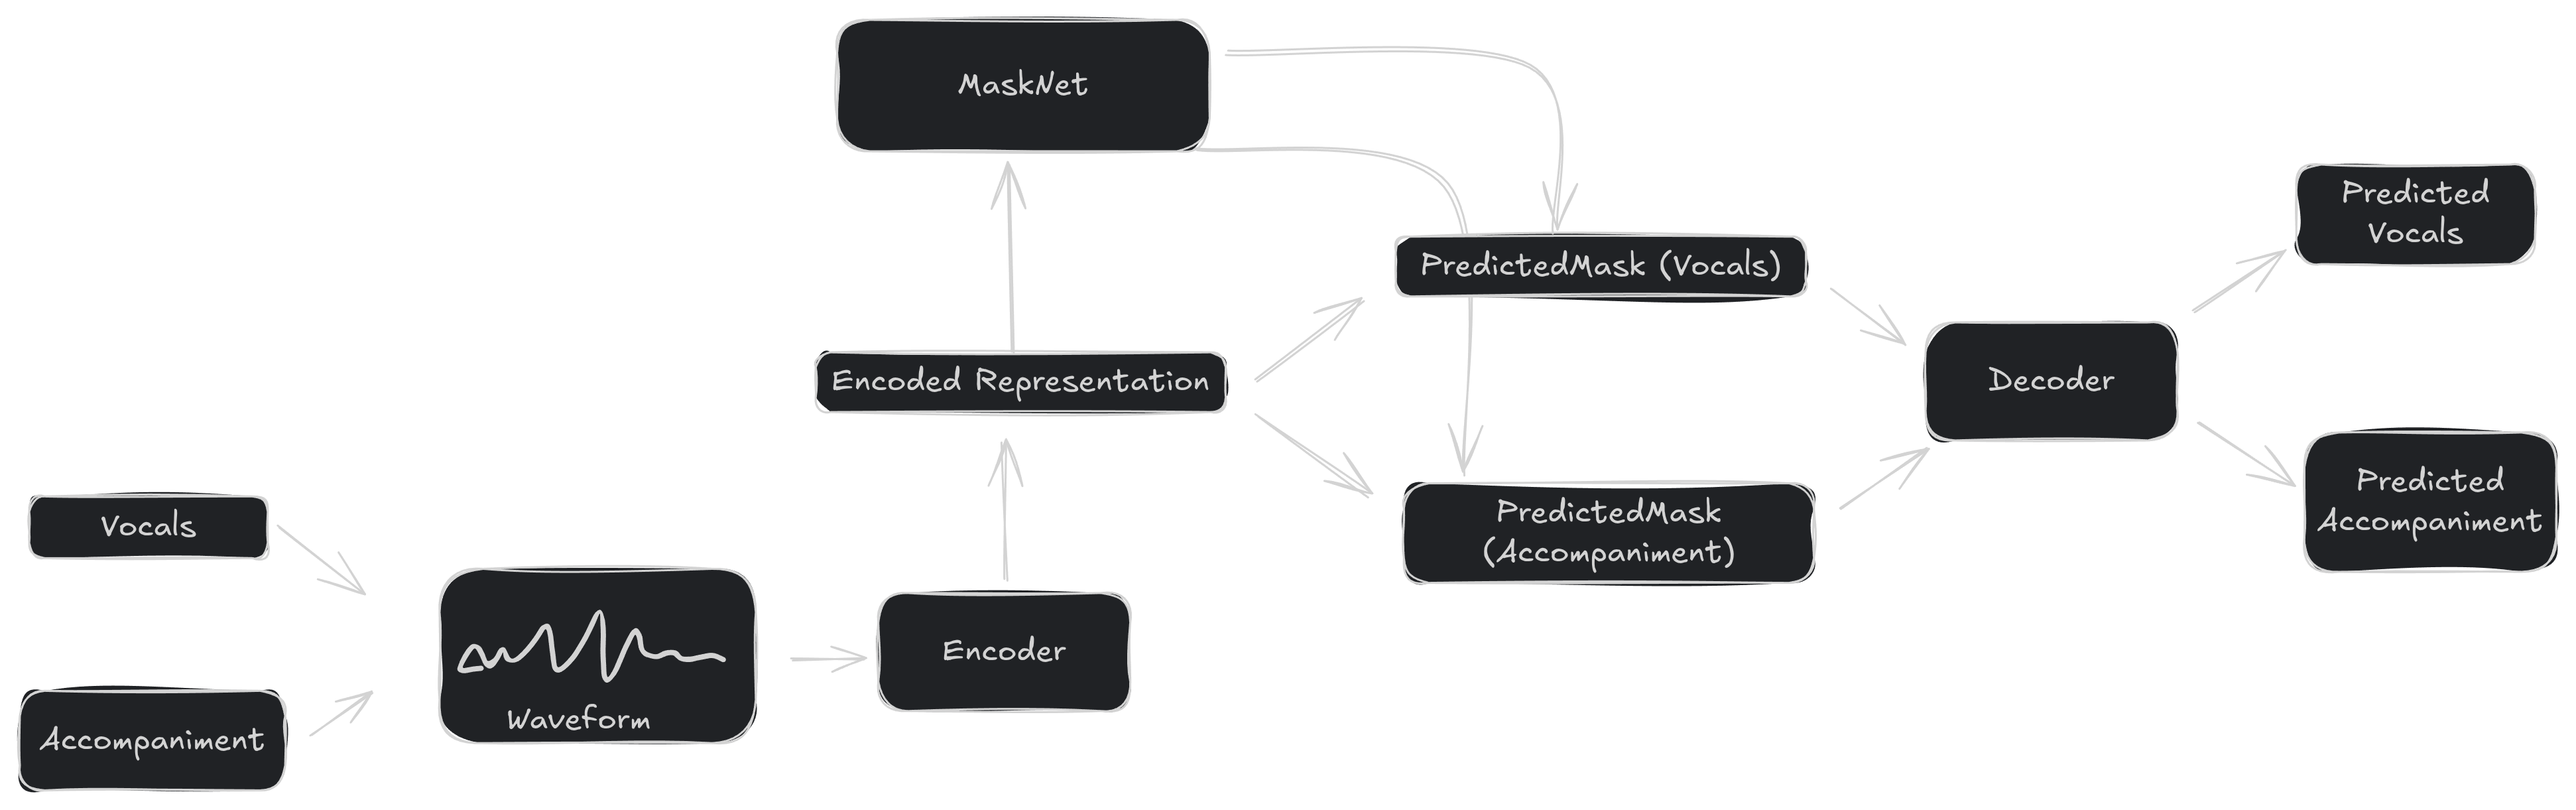

The original architecture begins with separate Vocal and Accompaniment inputs that are combined into a single Waveform. This waveform is then processed by an Encoder to produce an Encoded Representation. From this encoded signal, a MaskNet predicts distinct masks for the Vocals and Accompaniment sources. These predicted masks are applied to the Encoded Representation, which is then fed into a Decoder responsible for reconstructing the separated audio. The process concludes with the Decoder outputting the Predicted Vocals and Predicted Accompaniment streams.


### Locked IN
The idea I chose to pursue was to create masks in Sepformer in Mixture-of-Experts esque manner. This intent behind this idea is that the masknet learns various features to mask depending on the encoded representation and then a "Router" can be used to finally decide which features are more important to mask.
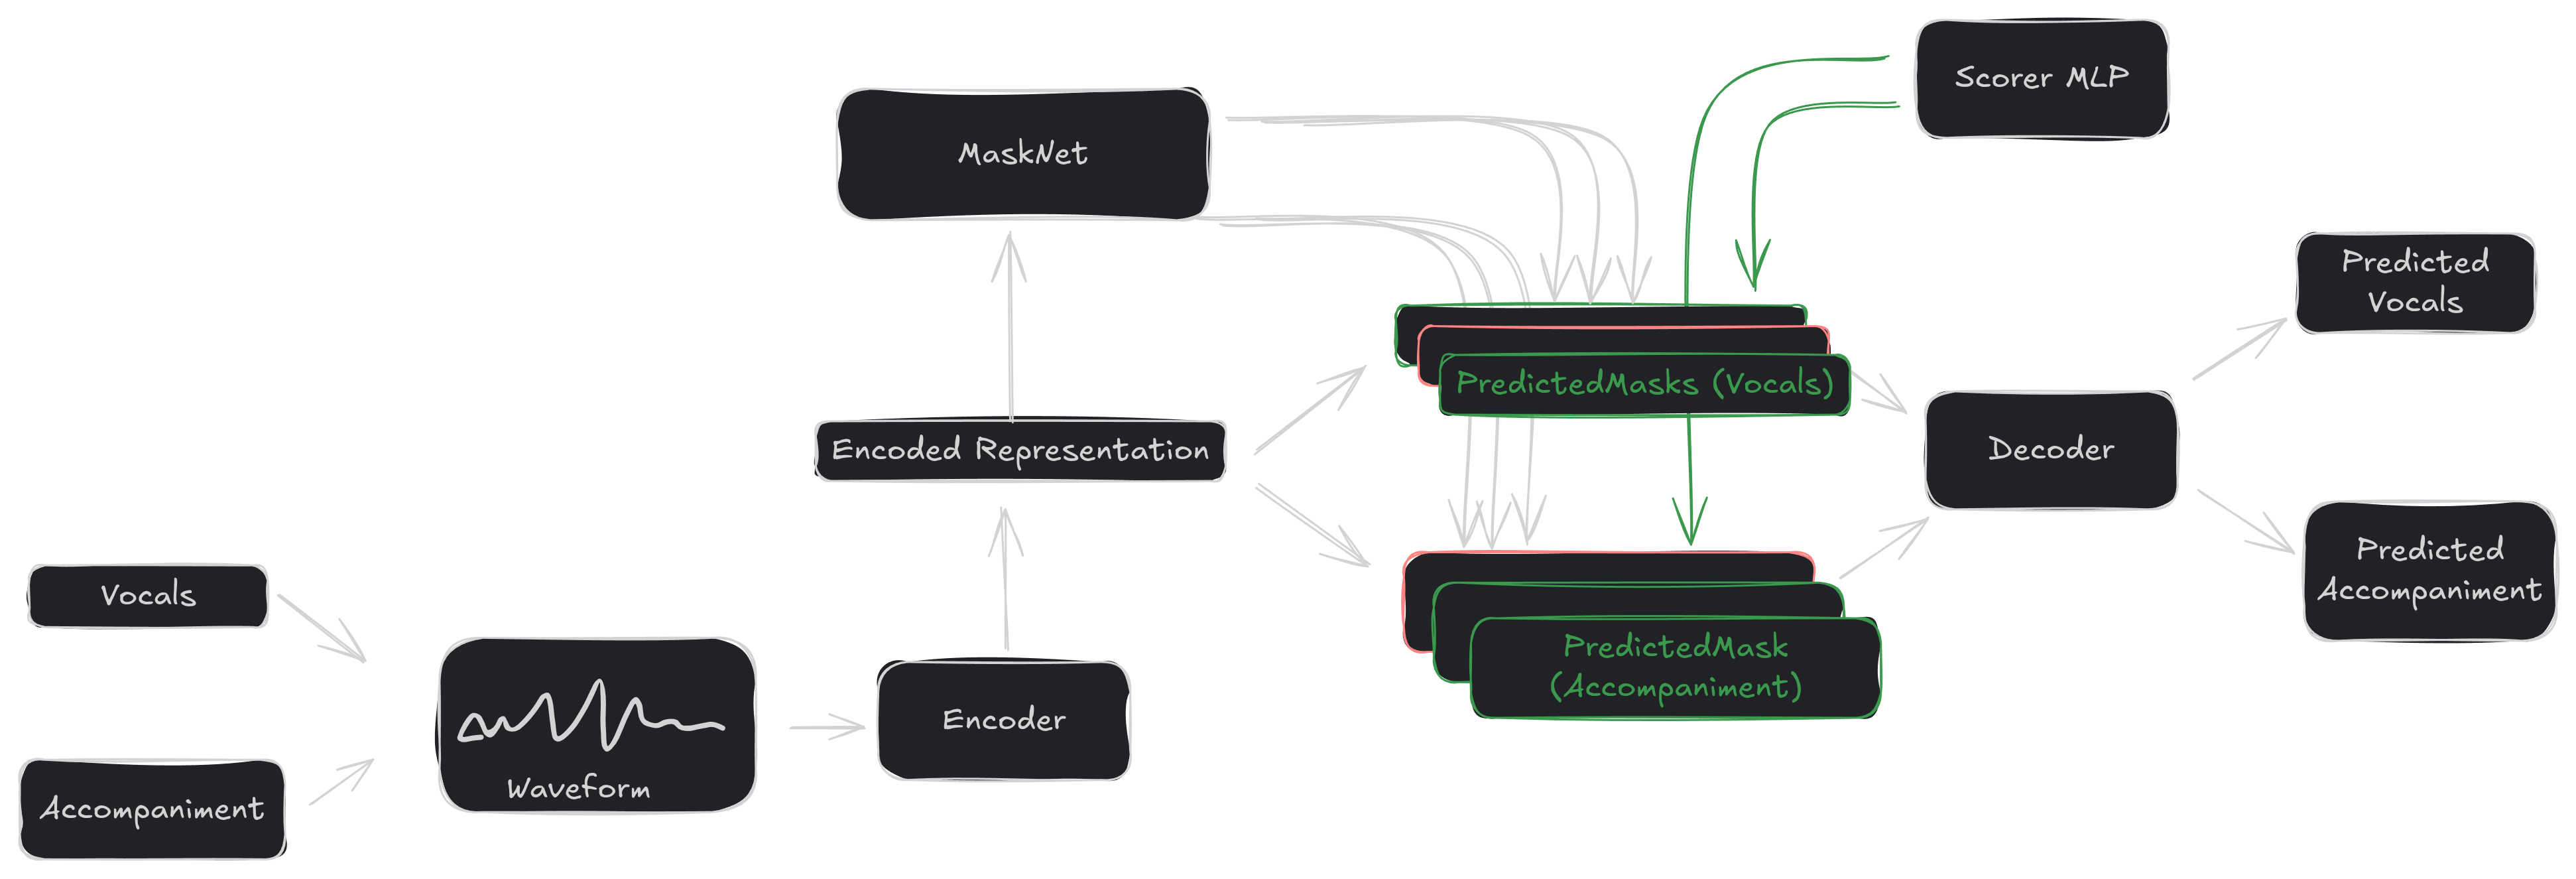
```
MaskNet: !new:speechbrain.lobes.models.dual_path.Dual_Path_Model
    num_spks: !ref <num_spks> * 10
    in_channels: !ref <N_encoder_out>
    out_channels: !ref <out_channels>
    num_layers: 2
    K: 250
    intra_model: !ref <SBtfintra>
    inter_model: !ref <SBtfinter>
    norm: ln
    linear_layer_after_inter_intra: False
    skip_around_intra: True
```


To generate multiple masks for each output stream, num_spks is just multiplied with the required number, in this case 10.

```
SPK_Scores1: !new:speechbrain.nnet.containers.Sequential
    input_shape: [1, 10, !ref <out_channels> ,7124]
    linear1: !name:speechbrain.nnet.linear.Linear
        n_neurons: !ref <dnn_neurons>
        bias: True
    activation: !new:torch.nn.LeakyReLU
    drop: !new:torch.nn.Dropout
        p: !ref <dropout>
    linear2: !name:speechbrain.nnet.linear.Linear
        n_neurons: !ref <dnn_neurons>
        bias: True
    activation2: !new:torch.nn.LeakyReLU
    drop2: !new:torch.nn.Dropout
        p: !ref <dropout>

    flatten: !new:torch.nn.Flatten

    linear_out: !name:speechbrain.nnet.linear.Linear
        n_neurons: 10
        bias: True
```

This MLP is used to generate a score for each of the given masks. Out of which the top 4 are chosen to be applied on the encoded representation and then passed to the decoder. MOE usually uses  some kind of diversity loss to ensure that experts are actually diverse and that the model doesn't always default to the same experts. In my implementation i am hoping that dropout of 0.5 produces a similar effect.

```
    # Separation
    mix_w = self.hparams.Encoder(mix)
    est_mask = self.hparams.MaskNet(mix_w)

    #Permuting batch to 0
    est_mask = est_mask.permute(1, 0, 2, 3)

    #Generating scoress for each mask
    g1_scores = self.hparams.SPK_Scores1(est_mask[:,0:10, :, :])
    g2_scores = self.hparams.SPK_Scores2(est_mask[:,10:20, :, :])
    est_mask = est_mask.permute(1, 0, 2, 3)

    #Selecting top 4 masks for targets
    topk_indices = torch.topk(g1_scores, k=4, dim=1).indices
    selected_masks = torch.squeeze(est_mask[topk_indices, :, :, :],0)
    group1_masks = torch.prod(selected_masks, dim=0)
    topk_indices = torch.topk(g2_scores, k=4, dim=1).indices + 10
    selected_masks = torch.squeeze(est_mask[topk_indices, :, :, :],0)
    group2_masks = torch.prod(selected_masks, dim=0)
    mix_w = torch.stack([mix_w] * self.hparams.num_spks)

    #Masks applied to encoded representation
    est_mask = torch.stack([group1_masks,group2_masks])
    sep_h = mix_w * est_mask
```

### Results

| average_scores| sdr | sdr_i | si-snr | si-snr_i |
|---|---|---|---|---|
| sepformer-simplified | -0.2828619177522576 | 21.529278453917517 | -3.3739551708102224 | 41.56113805770874 |
| moeformer-simplified | 0.06152996978484009 | 20.245213556731233 | -4.029459397460139 | 39.194006542826806 |

Here, moeformer, ie the MOE-esque sepformer model works a little better than base sepformer, but not good answers from either model.

In [ ]:
%%file trainmoe.py

#!/usr/bin/env/python3
"""Recipe for training a neural speech separation system on Libri2/3Mix datasets.
The system employs an encoder, a decoder, and a masking network.

To run this recipe, do the following:
> python train.py hparams/sepformer-libri2mix.yaml
> python train.py hparams/sepformer-libri3mix.yaml


The experiment file is flexible enough to support different neural
networks. By properly changing the parameter files, you can try
different architectures. The script supports both libri2mix and
libri3mix.


Authors
 * Cem Subakan 2020
 * Mirco Ravanelli 2020
 * Samuele Cornell 2020
 * Mirko Bronzi 2020
 * Jianyuan Zhong 2020
"""

import csv
import os
import sys

import numpy as np
import torch
import torch.nn.functional as F
import torchaudio
from hyperpyyaml import load_hyperpyyaml
from tqdm import tqdm

import speechbrain as sb
import speechbrain.nnet.schedulers as schedulers
from speechbrain.core import AMPConfig
from speechbrain.utils.distributed import run_on_main
from speechbrain.utils.logger import get_logger

logger = get_logger(__name__)


# Brain class for speech enhancement training
class Seperation(sb.Brain):
    """Class that manages the training loop. See speechbrain.core.Brain."""
    def cut_signals(self, mixture, targets):
        """This function selects a random segment of a given length within the mixture.
        The corresponding targets are selected accordingly"""
        randstart = torch.randint(
            0,
            1 + max(0, mixture.shape[1] - self.hparams.training_signal_len),
            (1,),
        ).item()
        if targets!=[]:
            targets = targets[
                :, randstart : randstart + self.hparams.training_signal_len, :
            ]
        mixture = mixture[
            :, randstart : randstart + self.hparams.training_signal_len
        ]
        return mixture, targets

    def compute_forward(self, mix, targets, stage, noise=None):
        """Forward computations from the mixture to the separated signals."""
        # Unpack lists and put tensors in the right device
        try:
            mix, _ = mix
        except:
            pass
        mix = mix.to(self.device)

        # Convert targets to tensor
        if len(targets) != 0:
            targets = torch.cat(
                [targets[i][0].unsqueeze(-1) for i in range(self.hparams.num_spks)],
                dim=-1,
            ).to(self.device)
            with torch.no_grad():
                if self.hparams.limit_training_signal_len:
                    mix, targets = self.cut_signals(mix, targets)

        # Separation
        mix_w = self.hparams.Encoder(mix)
        est_mask = self.hparams.MaskNet(mix_w)
        #Permuting batch to 0
        est_mask = est_mask.permute(1, 0, 2, 3)
        #Generating scoress for each mask
        g1_scores = self.hparams.SPK_Scores1(est_mask[:,0:10, :, :])
        g2_scores = self.hparams.SPK_Scores2(est_mask[:,10:20, :, :])
        est_mask = est_mask.permute(1, 0, 2, 3)
        #Selecting top 4 masks for targets
        topk_indices = torch.topk(g1_scores, k=4, dim=1).indices
        selected_masks = torch.squeeze(est_mask[topk_indices, :, :, :],0)
        group1_masks = torch.prod(selected_masks, dim=0)
        topk_indices = torch.topk(g2_scores, k=4, dim=1).indices + 10
        selected_masks = torch.squeeze(est_mask[topk_indices, :, :, :],0)
        group2_masks = torch.prod(selected_masks, dim=0)
        mix_w = torch.stack([mix_w] * self.hparams.num_spks)
        #Masks applied to encoded representation
        est_mask = torch.stack([group1_masks,group2_masks])
        sep_h = mix_w * est_mask

        # Decoding
        est_source = torch.cat(
            [
                self.hparams.Decoder(sep_h[i]).unsqueeze(-1)
                for i in range(self.hparams.num_spks)
            ],
            dim=-1,
        )

        # T changed after conv1d in encoder, fix it here
        T_origin = mix.size(1)
        T_est = est_source.size(1)
        if T_origin > T_est:
            est_source = F.pad(est_source, (0, 0, 0, T_origin - T_est))
        else:
            est_source = est_source[:, :T_origin, :]
        # print(est_source.shape,targets.shape)
        return est_source, targets

    def compute_objectives(self, predictions, targets):
        """Computes the si-snr loss"""
        return self.hparams.loss(targets, predictions)


    def fit_batch(self, batch):
        """Trains one batch"""
        # Unpacking batch list
        mixture = batch.mix_sig
        # targets = [batch.vocals, batch.drums, batch.bass, batch.other]
        targets = [batch.vocals, batch.drums]
        predictions, targets = self.compute_forward(
            mixture, targets, sb.Stage.TRAIN
        )
        loss = self.compute_objectives(predictions, targets)
        loss = loss.mean()
        if (
            loss.nelement() > 0 and loss < self.hparams.loss_upper_lim
        ):  # the fix for computational problems
            loss.backward()
            if self.hparams.clip_grad_norm >= 0:
                torch.nn.utils.clip_grad_norm_(
                    self.modules.parameters(),
                    self.hparams.clip_grad_norm,
                )
            self.optimizer.step()
        else:
            self.nonfinite_count += 1
            logger.info(
                "infinite loss or empty loss! it happened {} times so far - skipping this batch".format(
                    self.nonfinite_count
                )
            )
            loss.data = torch.tensor(0.0).to(self.device)
        self.optimizer.zero_grad()

        return loss.detach().cpu()


    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of each epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Set up statistics trackers for this stage
        self.loss_metric = sb.utils.metric_stats.MetricStats(
            metric=sb.nnet.losses.nll_loss
        )

        # Set up evaluation-only statistics trackers
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        # snt_id = batch.id
        mixture = batch.mix_sig
        targets = [batch.vocals, batch.drums]
        # targets = [batch.vocals, batch.drums, batch.bass, batch.other]
        with torch.no_grad():
            predictions, targets = self.compute_forward(mixture, targets, stage)
            loss = self.compute_objectives(predictions, targets)

        # Manage audio file saving
        if stage == sb.Stage.TEST and self.hparams.save_audio:
            if hasattr(self.hparams, "n_audio_to_save"):
                if self.hparams.n_audio_to_save > 0:
                    self.save_audio(batch.name, mixture, targets, predictions)
                    self.hparams.n_audio_to_save += -1
            else:
                self.save_audio(batch.name, mixture, targets, predictions)

        return loss.mean().detach()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"si-snr": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            # Learning rate annealing
            if isinstance(
                self.hparams.lr_scheduler, schedulers.ReduceLROnPlateau
            ):
                current_lr, next_lr = self.hparams.lr_scheduler(
                    [self.optimizer], epoch, stage_loss
                )
                schedulers.update_learning_rate(self.optimizer, next_lr)
            else:
                # if we do not use the reducelronplateau, we do not change the lr
                current_lr = self.hparams.optimizer.optim.param_groups[0]["lr"]

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": current_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"si-snr": stage_stats["si-snr"]},
                min_keys=["si-snr"],
            )
        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
    def save_results(self, test_data):
        """This script computes the SDR and SI-SNR metrics and saves
        them into a csv file"""

        # This package is required for SDR computation
        from mir_eval.separation import bss_eval_sources

        # Create folders where to store audio
        save_file = os.path.join(self.hparams.output_folder, "test_results.csv")

        # Variable init
        all_sdrs = []
        all_sdrs_i = []
        all_sisnrs = []
        all_sisnrs_i = []
        csv_columns = ["snt_id", "sdr", "sdr_i", "si-snr", "si-snr_i"]

        test_loader = sb.dataio.dataloader.make_dataloader(
            test_data, **self.hparams.dataloader_opts
        )

        with open(save_file, "w", newline="", encoding="utf-8") as results_csv:
            writer = csv.DictWriter(results_csv, fieldnames=csv_columns)
            writer.writeheader()

            # Loop over all test sentence
            with tqdm(test_loader, dynamic_ncols=True) as t:
                for i, batch in enumerate(t):
                    # Apply Separation
                    mixture, mix_len = batch.mix_sig
                    snt_id = batch.name
                    # targets = [batch.vocals, batch.drums, batch.bass, batch.other]
                    targets = [batch.vocals, batch.drums]
                    # print(targets)
                    with torch.no_grad():
                        predictions, targets = self.compute_forward(
                            batch.mix_sig, targets, sb.Stage.TEST
                        )
                    # Compute SI-SNR
                    sisnr = self.compute_objectives(predictions, targets)

                    cut_mix,_ = self.cut_signals(mixture,[])
                    # Compute SI-SNR improvement
                    mixture_signal = torch.stack(
                        [cut_mix] * self.hparams.num_spks, dim=-1
                    )
                    mixture_signal = mixture_signal.to(targets.device)
                    sisnr_baseline = self.compute_objectives(
                        mixture_signal, targets
                    )
                    sisnr_i = sisnr - sisnr_baseline
                    try:
                        # Compute SDR
                        sdr, _, _, _ = bss_eval_sources(
                            targets[0].t().cpu().numpy(),
                            predictions[0].t().detach().cpu().numpy(),
                        )

                        sdr_baseline, _, _, _ = bss_eval_sources(
                            targets[0].t().cpu().numpy(),
                            mixture_signal[0].t().detach().cpu().numpy(),
                        )

                        sdr_i = sdr.mean() - sdr_baseline.mean()

                        # Saving on a csv file
                        row = {
                            "snt_id": snt_id,
                            "sdr": sdr.mean(),
                            "sdr_i": sdr_i,
                            "si-snr": -sisnr.item(),
                            "si-snr_i": -sisnr_i.item(),
                        }
                        writer.writerow(row)

                        # Metric Accumulation
                        all_sdrs.append(sdr.mean())
                        all_sdrs_i.append(sdr_i.mean())
                        all_sisnrs.append(-sisnr.item())
                        all_sisnrs_i.append(-sisnr_i.item())
                    except ValueError as e:
                        # Catch potential mir_eval errors that might still occur in edge cases
                        print(f"Error processing sample {snt_id}: {e}")

                row = {
                    "snt_id": "avg",
                    "sdr": np.array(all_sdrs).mean(),
                    "sdr_i": np.array(all_sdrs_i).mean(),
                    "si-snr": np.array(all_sisnrs).mean(),
                    "si-snr_i": np.array(all_sisnrs_i).mean(),
                }
                writer.writerow(row)

        logger.info("Mean SISNR is {}".format(np.array(all_sisnrs).mean()))
        logger.info("Mean SISNRi is {}".format(np.array(all_sisnrs_i).mean()))
        logger.info("Mean SDR is {}".format(np.array(all_sdrs).mean()))
        logger.info("Mean SDRi is {}".format(np.array(all_sdrs_i).mean()))

    def save_audio(self, snt_id, mixture, targets, predictions):
        "saves the test audio (mixture, targets, and estimated sources) on disk"

        # Create output folder
        save_path = os.path.join(self.hparams.save_folder, "audio_results")
        if not os.path.exists(save_path):
            os.mkdir(save_path)

        for ns in range(self.hparams.num_spks):
            # Estimated source
            signal = predictions[0, :, ns]
            signal = signal / signal.abs().max()
            save_file = os.path.join(
                save_path, "item{}_source{}hat.wav".format(snt_id, ns + 1)
            )
            torchaudio.save(
                save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
            )

            # Original source
            if len(targets)!=0:
                signal = targets[0, :, ns]
                signal = signal / signal.abs().max()
                save_file = os.path.join(
                    save_path, "item{}_source{}.wav".format(snt_id, ns + 1)
                )
                torchaudio.save(
                    save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
                )

        # Mixture
        signal = mixture[0][0, :]
        signal = signal / signal.abs().max()
        save_file = os.path.join(save_path, "item{}_mix.wav".format(snt_id))
        torchaudio.save(
            save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
        )




def dataio_prep(hparams):
    """Creates data processing pipeline"""
    import musdb
    mus_train = musdb.DB(root="/notebooks/musdb18",subsets="train", split='train')
    mus_valid = musdb.DB(root="/notebooks/musdb18",subsets="train", split='valid')
    mus_test = musdb.DB(root="/notebooks/musdb18", subsets="test")
    train_data = {}
    valid_data= {}
    test_data = {}
    i = 0;
    for track in mus_train:
        i+=1
        dataobj={}
        dataobj['track'] = track
        train_data[track.name] = dataobj

    i = 0;
    for track in mus_valid:
        i+=1
        dataobj={}
        dataobj['track'] = track
        valid_data[track.name] = dataobj

    i = 0;
    for track in mus_test:
        i+=1
        dataobj={}
        dataobj['track'] = track
        test_data[track.name] = dataobj

    datasets = [
        sb.dataio.dataset.DynamicItemDataset(train_data),
        sb.dataio.dataset.DynamicItemDataset(valid_data),
        sb.dataio.dataset.DynamicItemDataset(test_data)
    ]

    @sb.utils.data_pipeline.takes("track")
    @sb.utils.data_pipeline.provides("name","mix_sig", "vocals","drums","bass","other")
    def audio_pipeline_mix(track):
        name = track.name

        mix_sig = torch.from_numpy(track.audio.T).float()
        mix_sig= torchaudio.functional.resample(mix_sig,track.rate,hparams['sample_rate'])[1,:]

        vocals = torch.from_numpy(track.sources['vocals'].audio.T).float()
        vocals = torchaudio.functional.resample(vocals,track.rate,hparams['sample_rate'])[1,:]

        drums = torch.from_numpy(track.sources['drums'].audio.T).float()
        drums = torchaudio.functional.resample(drums,track.rate,hparams['sample_rate'])[1,:]

        bass = torch.from_numpy(track.sources['bass'].audio.T).float()
        bass = torchaudio.functional.resample(bass,track.rate,hparams['sample_rate'])[1,:]

        other = torch.from_numpy(track.sources['other'].audio.T).float()
        other= torchaudio.functional.resample(other,track.rate,hparams['sample_rate'])[1,:]


        return name,mix_sig, vocals,drums,bass,other
    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline_mix)
    sb.dataio.dataset.set_output_keys(
        datasets, ["name", "mix_sig", "vocals", "drums"]
    )

    return datasets[0], datasets[1], datasets[2]


if __name__ == "__main__":
    # Load hyperparameters file with command-line overrides
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file, encoding="utf-8") as fin:
        hparams = load_hyperpyyaml(fin, overrides)


    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )


    # Data preparation
    train_data, valid_data, test_data = dataio_prep(hparams)

    # Brain class initialization
    separator = Seperation(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )
    # separator.infer_audio("/notebooks/musdb18/test/Al James - Schoolboy Facination.stem.mp4")


    # Training
    separator.fit(
        separator.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["dataloader_opts"],
        valid_loader_kwargs=hparams["dataloader_opts"],
    )

    # Eval
    separator.evaluate(test_data, min_key="si-snr")
    separator.save_results(test_data)

In [ ]:
%%file Transformermoe.yaml
# ################################
# Model: SepFormer for source separation
# https://arxiv.org/abs/2010.13154
# Dataset : Libri2mix
# ################################
#
# Basic parameters
# Seed needs to be set at top of yaml, before objects with parameters are made
#
seed: 1234
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Data params

# e.g. '/yourpath/Libri2Mix/train-clean-360/'
# the data folder is needed even if dynamic mixing is applied
data_folder: /yourpath/Libri2Mix/train-clean-360/

# this is the base folder for dynamic mixing
base_folder_dm: /yourpath/LibriSpeech/train-clean-360/

experiment_name: moe-scored-former-libri2mix
output_folder: !ref results/<experiment_name>/<seed>
train_log: !ref <output_folder>/train_log.txt
save_folder: !ref <output_folder>/save
train_data: !ref <save_folder>/libri2mix_train-360.csv
valid_data: !ref <save_folder>/libri2mix_dev.csv
test_data: !ref <save_folder>/libri2mix_test.csv
skip_prep: False

ckpt_interval_minutes: 60

# Experiment params
num_spks: 2
noprogressbar: False
save_audio: True # Save estimated sources on disk
sample_rate: 16000

####################### Training Parameters ####################################
N_epochs: 200
batch_size: 1
lr: 0.00015
clip_grad_norm: 5
loss_upper_lim: 999999  # this is the upper limit for an acceptable loss
# if True, the training sequences are cut to a specified length
limit_training_signal_len: True
# this is the length of sequences if we choose to limit
# the signal length of training sequences
training_signal_len: 57000

# Set it to True to dynamically create mixtures at training time
dynamic_mixing: False
use_wham_noise: False

# Speed perturbation
speed_changes: [95, 100, 105]  # List of speed changes for time-stretching

speed_perturb: !new:speechbrain.augment.time_domain.SpeedPerturb
    orig_freq: !ref <sample_rate>
    speeds: !ref <speed_changes>


# loss thresholding -- this thresholds the training loss
threshold_byloss: True
threshold: -30

# Encoder parameters
N_encoder_out: 256
out_channels: 256
kernel_size: 16
kernel_stride: 8
d_ffn: 1024
dropout: 0.5
dnn_neurons: 512

# Dataloader options
dataloader_opts:
    batch_size: !ref <batch_size>
    num_workers: 8


# Specifying the network
Encoder: !new:speechbrain.lobes.models.dual_path.Encoder
    kernel_size: !ref <kernel_size>
    out_channels: !ref <N_encoder_out>


SBtfintra: !new:speechbrain.lobes.models.dual_path.SBTransformerBlock
    num_layers: 8
    d_model: !ref <out_channels>
    nhead: 8
    d_ffn: !ref <d_ffn>
    dropout: 0
    use_positional_encoding: True
    norm_before: True

SBtfinter: !new:speechbrain.lobes.models.dual_path.SBTransformerBlock
    num_layers: 8
    d_model: !ref <out_channels>
    nhead: 8
    d_ffn: !ref <d_ffn>
    dropout: 0
    use_positional_encoding: True
    norm_before: True

MaskNet: !new:speechbrain.lobes.models.dual_path.Dual_Path_Model
    num_spks: !ref <num_spks> * 10
    in_channels: !ref <N_encoder_out>
    out_channels: !ref <out_channels>
    num_layers: 2
    K: 250
    intra_model: !ref <SBtfintra>
    inter_model: !ref <SBtfinter>
    norm: ln
    linear_layer_after_inter_intra: False
    skip_around_intra: True

Decoder: !new:speechbrain.lobes.models.dual_path.Decoder
    in_channels: !ref <N_encoder_out>
    out_channels: 1
    kernel_size: !ref <kernel_size>
    stride: !ref <kernel_stride>
    bias: False

#NEW MLP scorers for the 10 masks generated for each stream
SPK_Scores1: !new:speechbrain.nnet.containers.Sequential
    input_shape: [1, 10, 256 ,7124]
    linear1: !name:speechbrain.nnet.linear.Linear
        n_neurons: !ref <dnn_neurons>
        bias: True
    activation: !new:torch.nn.LeakyReLU
    drop: !new:torch.nn.Dropout
        p: !ref <dropout>
    linear2: !name:speechbrain.nnet.linear.Linear
        n_neurons: !ref <dnn_neurons>
        bias: True
    activation2: !new:torch.nn.LeakyReLU
    drop2: !new:torch.nn.Dropout
        p: !ref <dropout>

    flatten: !new:torch.nn.Flatten
        start_dim: 1

    linear_out: !name:speechbrain.nnet.linear.Linear
        n_neurons: 10
        bias: True

#NEW MLP scorers for the 10 masks generated for each stream
SPK_Scores2: !new:speechbrain.nnet.containers.Sequential
    input_shape: [1, 10, 256 ,7124]
    linear1: !name:speechbrain.nnet.linear.Linear
        n_neurons: !ref <dnn_neurons>
        bias: True
    activation: !new:torch.nn.LeakyReLU
    drop: !new:torch.nn.Dropout
        p: !ref <dropout>
    linear2: !name:speechbrain.nnet.linear.Linear
        n_neurons: !ref <dnn_neurons>
        bias: True
    activation2: !new:torch.nn.LeakyReLU
    drop2: !new:torch.nn.Dropout
        p: !ref <dropout>

    flatten: !new:torch.nn.Flatten
        start_dim: 1

    linear_out: !name:speechbrain.nnet.linear.Linear
        n_neurons: 10
        bias: True

optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0

loss: !name:speechbrain.nnet.losses.get_si_snr_with_pitwrapper

lr_scheduler: !new:speechbrain.nnet.schedulers.ReduceLROnPlateau
    factor: 0.5
    patience: 2
    dont_halve_until_epoch: 5

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <N_epochs>

modules:
    encoder: !ref <Encoder>
    decoder: !ref <Decoder>
    masknet: !ref <MaskNet>
    spk_scores1: !ref <SPK_Scores1>
    spk_scores2: !ref <SPK_Scores2>

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        encoder: !ref <Encoder>
        decoder: !ref <Decoder>
        masknet: !ref <MaskNet>
        spk_scores1: !ref <SPK_Scores1>
        spk_scores2: !ref <SPK_Scores2>
        counter: !ref <epoch_counter>
        # lr_scheduler: !ref <lr_scheduler>

train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

## Flint Stones (Stage-III)

### Paths of long ago
Over the course of my work I noticed several flaws with my original base model,
- The dataio module was significantly inefficient as it loaded the entire audio onto memory and then just cut it back to chunks, audio was resampled twice, unwanted targets were being loaded.
- For the sake of ease of development and simplicity, I had initially omitted crucial parts of sepformer such as WHAM noise, speed perturbation, frequency and time chunk dropping, dynamic mixing, reduced precision.

This meant that my models were being trained rather slow and possibly had worse performance.

For this reason, everything other than WHAM and dynamic mixing was reintroduced to the model, and this lead to a significant improvement to performance.

Largely due to the dataio pipeline being improved:
```
def dataio_prep(hparams):
    """Creates data processing pipeline"""
    import musdb
    import random

    #Sampling at required frequency done here itself while loading

    mus_train = musdb.DB(root="/notebooks/musdb18",subsets="train", split='train', sample_rate = hparams['sample_rate'])
    mus_valid = musdb.DB(root="/notebooks/musdb18",subsets="train", split='valid', sample_rate = hparams['sample_rate'])
    mus_test = musdb.DB(root="/notebooks/musdb18", subsets="test", sample_rate = hparams['sample_rate'])
     
     .....

    @sb.utils.data_pipeline.takes("track")
    @sb.utils.data_pipeline.provides("name","mix_sig", "vocals","accompaniment")
    def audio_pipeline_mix(track):
        name = track.name

        #Chunks generated as required instead of reading entire signal on to memory

        track.chunk_duration = hparams["audio_length"]
        track.chunk_start = random.uniform(0, track.duration - track.chunk_duration)

        mix_sig = torch.from_numpy(track.audio.T)[1].float()

        vocals = torch.from_numpy(track.sources['vocals'].audio.T)[1].float()

        accompaniment = torch.from_numpy(track.targets['accompaniment'].audio.T)[1].float()
        return name,mix_sig, vocals,accompaniment

     ....
```

The reason for not including WHAM is that this form of noise added significant overhead to the resources available to me and further this noise is noise gathered from real world settings, meaning it may consist poisonous noise that may tarnish our MUSDB dataset.

### Results

| Experiment Name | sdr | sdr_i | si-snr | si-snr_i |
|---|---|---|---|---|
| moeformer-speed | 4.096558889472422 | 3.663513556686842 | 1.6396042471346648 | 2.1655070626217388 |

The above improvements have significantly improved the performance of the model itself and even the training is much much faster due to the changes made. This means that noise plays a very important role in model performance.

In [ ]:
%%file trainmoespeed.py
#!/usr/bin/env/python3
"""Recipe for training a neural speech separation system on Libri2/3Mix datasets.
The system employs an encoder, a decoder, and a masking network.

To run this recipe, do the following:
> python train.py hparams/sepformer-libri2mix.yaml
> python train.py hparams/sepformer-libri3mix.yaml


The experiment file is flexible enough to support different neural
networks. By properly changing the parameter files, you can try
different architectures. The script supports both libri2mix and
libri3mix.


Authors
 * Cem Subakan 2020
 * Mirco Ravanelli 2020
 * Samuele Cornell 2020
 * Mirko Bronzi 2020
 * Jianyuan Zhong 2020
"""

import csv
import os
import sys

import numpy as np
import torch
import torch.nn.functional as F
import torchaudio
from hyperpyyaml import load_hyperpyyaml
from tqdm import tqdm

import speechbrain as sb
import speechbrain.nnet.schedulers as schedulers
from speechbrain.utils.distributed import run_on_main
from speechbrain.utils.logger import get_logger

logger = get_logger(__name__)


# Define training procedure
class Separation(sb.Brain):
    def compute_forward(self, mix, targets, stage, noise=None):
        """Forward computations from the mixture to the separated signals."""

        # Unpack lists and put tensors in the right device
        mix, mix_lens = mix
        mix, mix_lens = mix.to(self.device), mix_lens.to(self.device)
        # Convert targets to tensor
        targets = torch.cat(
            [targets[i][0].unsqueeze(-1) for i in range(self.hparams.num_spks)],
            dim=-1,
        ).to(self.device)

        # Add speech distortions
        if stage == sb.Stage.TRAIN:
            with torch.no_grad():
                if self.hparams.use_speedperturb or self.hparams.use_rand_shift:
                    mix, targets = self.add_speed_perturb(targets, mix_lens)

                    mix = targets.sum(-1)

                if self.hparams.use_wavedrop:
                    mix = self.hparams.drop_chunk(mix, mix_lens)
                    mix = self.hparams.drop_freq(mix)

                if self.hparams.limit_training_signal_len:
                    mix, targets = self.cut_signals(mix, targets)

        # Separation
        mix_w = self.hparams.Encoder(mix)
        est_mask = self.hparams.MaskNet(mix_w)

        est_mask = est_mask.permute(1, 0, 2, 3)
        g1_scores = self.hparams.SPK_Scores1(est_mask[:,0:10, :, :])
        g2_scores = self.hparams.SPK_Scores2(est_mask[:,10:20, :, :])
        est_mask = est_mask.permute(1, 0, 2, 3)
        topk_indices = torch.topk(g1_scores, k=4, dim=1).indices
        selected_masks = torch.squeeze(est_mask[topk_indices, :, :, :],0)
        group1_masks = torch.prod(selected_masks, dim=0)
        topk_indices = torch.topk(g2_scores, k=4, dim=1).indices + 10
        selected_masks = torch.squeeze(est_mask[topk_indices, :, :, :],0)
        group2_masks = torch.prod(selected_masks, dim=0)
        est_mask = torch.stack([group1_masks,group2_masks])

        mix_w = torch.stack([mix_w] * self.hparams.num_spks)
        sep_h = mix_w * est_mask


        # Decoding
        est_source = torch.cat(
            [
                self.hparams.Decoder(sep_h[i]).unsqueeze(-1)
                for i in range(self.hparams.num_spks)
            ],
            dim=-1,
        )

        # T changed after conv1d in encoder, fix it here
        T_origin = mix.size(1)
        T_est = est_source.size(1)
        if T_origin > T_est:
            est_source = F.pad(est_source, (0, 0, 0, T_origin - T_est))
        else:
            est_source = est_source[:, :T_origin, :]

        return est_source, targets

    def compute_objectives(self, predictions, targets):
        """Computes the si-snr loss"""
        return self.hparams.loss(targets, predictions)

    def fit_batch(self, batch):
        """Trains one batch"""

        # Unpacking batch list
        mixture = batch.mix_sig
        targets = [batch.vocals, batch.accompaniment]
        noise = None
        with self.training_ctx:
            predictions, targets = self.compute_forward(
                mixture, targets, sb.Stage.TRAIN, noise
            )
            loss = self.compute_objectives(predictions, targets)

            # hard threshold the easy dataitems
            if self.hparams.threshold_byloss:
                th = self.hparams.threshold
                loss = loss[loss > th]
                if loss.nelement() > 0:
                    loss = loss.mean()
            else:
                loss = loss.mean()

        if loss.nelement() > 0 and loss < self.hparams.loss_upper_lim:
            self.scaler.scale(loss).backward()
            if self.hparams.clip_grad_norm >= 0:
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(
                    self.modules.parameters(),
                    self.hparams.clip_grad_norm,
                )
            self.scaler.step(self.optimizer)
            self.scaler.update()
        else:
            self.nonfinite_count += 1
            logger.info(
                "infinite loss or empty loss! it happened {} times so far - skipping this batch".format(
                    self.nonfinite_count
                )
            )
            loss.data = torch.tensor(0.0).to(self.device)
        self.optimizer.zero_grad()

        return loss.detach().cpu()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        snt_id = batch.name
        mixture = batch.mix_sig
        targets = [batch.vocals, batch.accompaniment]

        with torch.no_grad():
            predictions, targets = self.compute_forward(mixture, targets, stage)
            loss = self.compute_objectives(predictions, targets)

        # Manage audio file saving
        if stage == sb.Stage.TEST and self.hparams.save_audio:
            if hasattr(self.hparams, "n_audio_to_save"):
                if self.hparams.n_audio_to_save > 0:
                    self.save_audio(snt_id, mixture, targets, predictions)
                    self.hparams.n_audio_to_save += -1
            else:
                self.save_audio(snt_id, mixture, targets, predictions)

        return loss.mean().detach()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"si-snr": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            # Learning rate annealing
            if isinstance(
                self.hparams.lr_scheduler, schedulers.ReduceLROnPlateau
            ):
                current_lr, next_lr = self.hparams.lr_scheduler(
                    [self.optimizer], epoch, stage_loss
                )
                schedulers.update_learning_rate(self.optimizer, next_lr)
            else:
                # if we do not use the reducelronplateau, we do not change the lr
                current_lr = self.hparams.optimizer.optim.param_groups[0]["lr"]

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": current_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"si-snr": stage_stats["si-snr"]},
                min_keys=["si-snr"],
            )
        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
    def add_speed_perturb(self, targets, targ_lens):
        original_len = targets.shape[1]
        num_sources = targets.shape[-1]
        processed_targets_list = []

        for i in range(num_sources):
            current_source = targets[:, :, i]

            processed_source = current_source

            if self.hparams.use_speedperturb:
                processed_source = self.hparams.speed_perturb(current_source)

                if self.hparams.use_rand_shift:
                     max_shift_actual = min(self.hparams.max_shift, processed_source.shape[1])
                     min_shift_actual = max(self.hparams.min_shift, -processed_source.shape[1])

                     if max_shift_actual > min_shift_actual:
                         rand_shift = torch.randint(
                             min_shift_actual, max_shift_actual + 1, (1,),
                             device=processed_source.device
                         )
                         processed_source = torch.roll(
                             processed_source, shifts=(rand_shift[0].item(),), dims=1
                         )

            current_len = processed_source.shape[1]

            if current_len > original_len:
                processed_source = processed_source[:, :original_len]

            elif current_len < original_len:
                padding_needed = original_len - current_len
                padding_sequence = processed_source[:, -padding_needed:]
                processed_source = torch.cat((processed_source, padding_sequence), dim=1)

            processed_targets_list.append(processed_source.to(targets.device))

        targets = torch.stack(processed_targets_list, dim=-1)

        mix = targets.sum(dim=-1)

        return mix, targets


    def cut_signals(self, mixture, targets):
        """This function selects a random segment of a given length within the mixture.
        The corresponding targets are selected accordingly"""
        randstart = torch.randint(
            0,
            1 + max(0, mixture.shape[1] - self.hparams.training_signal_len),
            (1,),
        ).item()
        targets = targets[
            :, randstart : randstart + self.hparams.training_signal_len, :
        ]
        mixture = mixture[
            :, randstart : randstart + self.hparams.training_signal_len
        ]
        return mixture, targets

    def reset_layer_recursively(self, layer):
        """Reinitializes the parameters of the neural networks"""
        if hasattr(layer, "reset_parameters"):
            layer.reset_parameters()
        for child_layer in layer.modules():
            if layer != child_layer:
                self.reset_layer_recursively(child_layer)

    def save_results(self, test_data):
        """This script computes the SDR and SI-SNR metrics and saves
        them into a csv file"""

        # This package is required for SDR computation
        from mir_eval.separation import bss_eval_sources

        # Create folders where to store audio
        save_file = os.path.join(self.hparams.output_folder, "test_results.csv")

        # Variable init
        all_sdrs = []
        all_sdrs_i = []
        all_sisnrs = []
        all_sisnrs_i = []
        csv_columns = ["snt_id", "sdr", "sdr_i", "si-snr", "si-snr_i"]

        test_loader = sb.dataio.dataloader.make_dataloader(
            test_data, **self.hparams.dataloader_opts
        )

        with open(save_file, "w", newline="", encoding="utf-8") as results_csv:
            writer = csv.DictWriter(results_csv, fieldnames=csv_columns)
            writer.writeheader()

            # Loop over all test sentence
            with tqdm(test_loader, dynamic_ncols=True) as t:
                for i, batch in enumerate(t):
                    # Apply Separation
                    mixture, mix_len = batch.mix_sig
                    snt_id = batch.name
                    targets = [batch.vocals, batch.accompaniment]

                    with torch.no_grad():
                        predictions, targets = self.compute_forward(
                            batch.mix_sig, targets, sb.Stage.TEST
                        )

                    # Compute SI-SNR
                    sisnr = self.compute_objectives(predictions, targets)

                    # Compute SI-SNR improvement
                    mixture_signal = torch.stack(
                        [mixture] * self.hparams.num_spks, dim=-1
                    )
                    mixture_signal = mixture_signal.to(targets.device)
                    sisnr_baseline = self.compute_objectives(
                        mixture_signal, targets
                    )
                    sisnr_i = sisnr - sisnr_baseline


                    try:
                        # Compute SDR
                        sdr, _, _, _ = bss_eval_sources(
                            targets[0].t().cpu().numpy(),
                            predictions[0].t().detach().cpu().numpy(),
                        )

                        sdr_baseline, _, _, _ = bss_eval_sources(
                            targets[0].t().cpu().numpy(),
                            mixture_signal[0].t().detach().cpu().numpy(),
                        )

                        sdr_i = sdr.mean() - sdr_baseline.mean()

                        # Saving on a csv file
                        row = {
                            "snt_id": snt_id,
                            "sdr": sdr.mean(),
                            "sdr_i": sdr_i,
                            "si-snr": -sisnr.item(),
                            "si-snr_i": -sisnr_i.item(),
                        }
                        writer.writerow(row)

                        # Metric Accumulation
                        all_sdrs.append(sdr.mean())
                        all_sdrs_i.append(sdr_i.mean())
                        all_sisnrs.append(-sisnr.item())
                        all_sisnrs_i.append(-sisnr_i.item())
                    except ValueError as e:
                        # Catch potential mir_eval errors that might still occur in edge cases
                        print(f"Error processing sample {snt_id}: {e}")

                row = {
                    "snt_id": "avg",
                    "sdr": np.array(all_sdrs).mean(),
                    "sdr_i": np.array(all_sdrs_i).mean(),
                    "si-snr": np.array(all_sisnrs).mean(),
                    "si-snr_i": np.array(all_sisnrs_i).mean(),
                }
                writer.writerow(row)

        logger.info("Mean SISNR is {}".format(np.array(all_sisnrs).mean()))
        logger.info("Mean SISNRi is {}".format(np.array(all_sisnrs_i).mean()))
        logger.info("Mean SDR is {}".format(np.array(all_sdrs).mean()))
        logger.info("Mean SDRi is {}".format(np.array(all_sdrs_i).mean()))

    def save_audio(self, snt_id, mixture, targets, predictions):
        "saves the test audio (mixture, targets, and estimated sources) on disk"

        # Create output folder
        save_path = os.path.join(self.hparams.save_folder, "audio_results")
        if not os.path.exists(save_path):
            os.mkdir(save_path)

        for ns in range(self.hparams.num_spks):
            # Estimated source
            signal = predictions[0, :, ns]
            signal = signal / signal.abs().max()
            save_file = os.path.join(
                save_path, "item{}_source{}hat.wav".format(snt_id, ns + 1)
            )
            torchaudio.save(
                save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
            )

            # Original source
            signal = targets[0, :, ns]
            signal = signal / signal.abs().max()
            save_file = os.path.join(
                save_path, "item{}_source{}.wav".format(snt_id, ns + 1)
            )
            torchaudio.save(
                save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
            )

        # Mixture
        signal = mixture[0][0, :]
        signal = signal / signal.abs().max()
        save_file = os.path.join(save_path, "item{}_mix.wav".format(snt_id))
        torchaudio.save(
            save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
        )


def dataio_prep(hparams):
    """Creates data processing pipeline"""
    import musdb
    import random
    mus_train = musdb.DB(root="/notebooks/musdb18",subsets="train", split='train', sample_rate = hparams['sample_rate'])
    mus_valid = musdb.DB(root="/notebooks/musdb18",subsets="train", split='valid', sample_rate = hparams['sample_rate'])
    mus_test = musdb.DB(root="/notebooks/musdb18", subsets="test", sample_rate = hparams['sample_rate'])
    train_data = {}
    valid_data= {}
    test_data = {}
    for track in mus_train:
        dataobj={}
        dataobj['track'] = track
        train_data[track.name] = dataobj

    for track in mus_valid:
        dataobj={}
        dataobj['track'] = track
        valid_data[track.name] = dataobj

    for track in mus_test:
        dataobj={}
        dataobj['track'] = track
        test_data[track.name] = dataobj

    datasets = [
        sb.dataio.dataset.DynamicItemDataset(train_data),
        sb.dataio.dataset.DynamicItemDataset(valid_data),
        sb.dataio.dataset.DynamicItemDataset(test_data)
    ]

    @sb.utils.data_pipeline.takes("track")
    @sb.utils.data_pipeline.provides("name","mix_sig", "vocals","accompaniment")
    def audio_pipeline_mix(track):
        name = track.name
        track.chunk_duration = hparams["audio_length"]
        track.chunk_start = random.uniform(0, track.duration - track.chunk_duration)

        mix_sig = torch.from_numpy(track.audio.T)[1].float()

        vocals = torch.from_numpy(track.sources['vocals'].audio.T)[1].float()

        accompaniment = torch.from_numpy(track.targets['accompaniment'].audio.T)[1].float()
        return name,mix_sig, vocals,accompaniment

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline_mix)
    sb.dataio.dataset.set_output_keys(
        datasets, ["name", "mix_sig", "vocals", "accompaniment"]
    )

    return datasets[0], datasets[1], datasets[2]

if __name__ == "__main__":
    # Load hyperparameters file with command-line overrides
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file, encoding="utf-8") as fin:
        hparams = load_hyperpyyaml(fin, overrides)
    run_opts['device']="cuda"
    print(run_opts)
    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Update precision to bf16 if the device is CPU and precision is fp16
    if run_opts.get("device") == "cpu" and hparams.get("precision") == "fp16":
        hparams["precision"] = "bf16"

    train_data, valid_data, test_data = dataio_prep(hparams)

    # Load pretrained model if pretrained_separator is present in the yaml
    if "pretrained_separator" in hparams:
        run_on_main(hparams["pretrained_separator"].collect_files)
        hparams["pretrained_separator"].load_collected()

    # Brain class initialization
    separator = Separation(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # re-initialize the parameters if we don't use a pretrained model
    if "pretrained_separator" not in hparams:
        for module in separator.modules.values():
            separator.reset_layer_recursively(module)

    # Training
    separator.fit(
        separator.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["dataloader_opts"],
        valid_loader_kwargs=hparams["dataloader_opts"],
    )

    # Eval
    separator.evaluate(test_data, min_key="si-snr")
    separator.save_results(test_data)

In [ ]:
%%file Transformermoespeed.yaml
# ################################
# Model: SepFormer for source separation
# https://arxiv.org/abs/2010.13154
# Dataset : Libri2mix
# ################################
#
# Basic parameters
# Seed needs to be set at top of yaml, before objects with parameters are made
#
seed: 1234
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Data params

# e.g. '/yourpath/Libri2Mix/train-clean-360/'
# the data folder is needed even if dynamic mixing is applied
data_folder: /yourpath/Libri2Mix/train-clean-360/

experiment_name: moespeed-scored-former-libri2mix
output_folder: !ref results/<experiment_name>/<seed>
train_log: !ref <output_folder>/train_log.txt
save_folder: !ref <output_folder>/save
train_data: !ref <save_folder>/libri2mix_train-360.csv
valid_data: !ref <save_folder>/libri2mix_dev.csv
test_data: !ref <save_folder>/libri2mix_test.csv
skip_prep: False

ckpt_interval_minutes: 60

# Experiment params
precision: fp16 # bf16, fp16 or fp32 # Set it to True for mixed precision
num_spks: 2
noprogressbar: False
save_audio: True # Save estimated sources on disk
sample_rate: 16000

####################### Training Parameters ####################################
N_epochs: 100
batch_size: 1
lr: 0.00015
clip_grad_norm: 5
loss_upper_lim: 999999  # this is the upper limit for an acceptable loss
# if True, the training sequences are cut to a specified length
limit_training_signal_len: False
# this is the length of sequences if we choose to limit
# the signal length of training sequences
training_signal_len: 57000
audio_length: 6


# Parameters for data augmentation
use_wavedrop: True
use_speedperturb: True
use_rand_shift: True
min_shift: -8000
max_shift: 8000

# Speed perturbation
speed_changes: [95, 100, 105]  # List of speed changes for time-stretching

speed_perturb: !new:speechbrain.augment.time_domain.SpeedPerturb
    orig_freq: !ref <sample_rate>
    speeds: !ref <speed_changes>

# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 5  # Max number of audio chunks to drop
drop_chunk_length_low: 1000  # Min length of audio chunks to drop
drop_chunk_length_high: 2000  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>


# loss thresholding -- this thresholds the training loss
threshold_byloss: True
threshold: -30

# Encoder parameters
N_encoder_out: 256
out_channels: 256
kernel_size: 16
kernel_stride: 8
d_ffn: 1024
dropout: 0.5
dnn_neurons: 512

# Dataloader options
dataloader_opts:
    batch_size: !ref <batch_size>
    num_workers: 8


# Specifying the network
Encoder: !new:speechbrain.lobes.models.dual_path.Encoder
    kernel_size: !ref <kernel_size>
    out_channels: !ref <N_encoder_out>


SBtfintra: !new:speechbrain.lobes.models.dual_path.SBTransformerBlock
    num_layers: 8
    d_model: !ref <out_channels>
    nhead: 8
    d_ffn: !ref <d_ffn>
    dropout: 0
    use_positional_encoding: True
    norm_before: True

SBtfinter: !new:speechbrain.lobes.models.dual_path.SBTransformerBlock
    num_layers: 8
    d_model: !ref <out_channels>
    nhead: 8
    d_ffn: !ref <d_ffn>
    dropout: 0
    use_positional_encoding: True
    norm_before: True

MaskNet: !new:speechbrain.lobes.models.dual_path.Dual_Path_Model
    num_spks: !ref <num_spks> * 10
    in_channels: !ref <N_encoder_out>
    out_channels: !ref <out_channels>
    num_layers: 2
    K: 250
    intra_model: !ref <SBtfintra>
    inter_model: !ref <SBtfinter>
    norm: ln
    linear_layer_after_inter_intra: False
    skip_around_intra: True

Decoder: !new:speechbrain.lobes.models.dual_path.Decoder
    in_channels: !ref <N_encoder_out>
    out_channels: 1
    kernel_size: !ref <kernel_size>
    stride: !ref <kernel_stride>
    bias: False

SPK_Scores1: !new:speechbrain.nnet.containers.Sequential
    input_shape: [1, 10, 256 ,11999]
    linear1: !name:speechbrain.nnet.linear.Linear
        n_neurons: !ref <dnn_neurons>
        bias: True
    activation: !new:torch.nn.LeakyReLU
    drop: !new:torch.nn.Dropout
        p: !ref <dropout>
    linear2: !name:speechbrain.nnet.linear.Linear
        n_neurons: !ref <dnn_neurons>
        bias: True
    activation2: !new:torch.nn.LeakyReLU
    drop2: !new:torch.nn.Dropout
        p: !ref <dropout>

    flatten: !new:torch.nn.Flatten
        start_dim: 1

    linear_out: !name:speechbrain.nnet.linear.Linear
        n_neurons: 10
        bias: True

SPK_Scores2: !new:speechbrain.nnet.containers.Sequential
    input_shape: [1, 10, 256 ,11999] # Input shape: [Batch, Channel, Feature1, Feature2]
    linear1: !name:speechbrain.nnet.linear.Linear
        n_neurons: !ref <dnn_neurons>
        bias: True
    # bn1: !name:speechbrain.nnet.normalization.BatchNorm1d
    activation: !new:torch.nn.LeakyReLU
    drop: !new:torch.nn.Dropout
        p: !ref <dropout>
    linear2: !name:speechbrain.nnet.linear.Linear
        n_neurons: !ref <dnn_neurons>
        bias: True
    # bn2: !name:speechbrain.nnet.normalization.BatchNorm1d
    activation2: !new:torch.nn.LeakyReLU
    drop2: !new:torch.nn.Dropout
        p: !ref <dropout>

    # --- Layers added to achieve [Batch, 10] output ---
    # At this point, the shape is [10, 1, 256, dnn_neurons]
    flatten: !new:torch.nn.Flatten
        # Flatten from the dimension after the batch dimension (dim 1)
        # This collapses [1, 256, dnn_neurons] into a single dimension
        start_dim: 1
    # Shape after flatten: [10, 1 * 256 * dnn_neurons] (e.g., [10, 256 * dnn_neurons])

    linear_out: !name:speechbrain.nnet.linear.Linear
        # This final linear layer projects the flattened features to 10 scores
        n_neurons: 10
        bias: True
    # Shape after linear_out: [10, 10] (Matches the desired output shape)

optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0

loss: !name:speechbrain.nnet.losses.get_si_snr_with_pitwrapper

lr_scheduler: !new:speechbrain.nnet.schedulers.ReduceLROnPlateau
    factor: 0.5
    patience: 2
    dont_halve_until_epoch: 5

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <N_epochs>

modules:
    encoder: !ref <Encoder>
    decoder: !ref <Decoder>
    masknet: !ref <MaskNet>
    spk_scores1: !ref <SPK_Scores1>
    spk_scores2: !ref <SPK_Scores2>

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        encoder: !ref <Encoder>
        decoder: !ref <Decoder>
        masknet: !ref <MaskNet>
        spk_scores1: !ref <SPK_Scores1>
        spk_scores2: !ref <SPK_Scores2>
        counter: !ref <epoch_counter>
        # lr_scheduler: !ref <lr_scheduler>

train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

### Did the concrete even help?

Since changes have not been isolated, its difficult to isolate what changes helped model performance and what did not, So as a test for the efficacy of my MOE-esque masking model, I ran the base sepformer with the speedups included without the architectural changes.

Well, turns out it did not after running we get ever so slightly better results just with the base architecture

###Results:

| Experiment Name | sdr | sdr_i | si-snr | si-snr_i |
|---|---|---|---|---|
| sepformer-speed| 4.4323612703560356 | 4.085778598380623 | 2.675037780874654 | 2.808835374681573 |
| moeformer-speed | 4.096558889472422 | 3.663513556686842 | 1.6396042471346648 | 2.1655070626217388 |

Unfortunately, Base-architecture pull ahead here slightly, this might even have the case in the comparison we made in Stage-II but perhaps slight changes in architecture might have mudled those results.


In [ ]:
%%file trainpurespeed.py
#!/usr/bin/env/python3
"""Recipe for training a neural speech separation system on Libri2/3Mix datasets.
The system employs an encoder, a decoder, and a masking network.

To run this recipe, do the following:
> python train.py hparams/sepformer-libri2mix.yaml
> python train.py hparams/sepformer-libri3mix.yaml


The experiment file is flexible enough to support different neural
networks. By properly changing the parameter files, you can try
different architectures. The script supports both libri2mix and
libri3mix.


Authors
 * Cem Subakan 2020
 * Mirco Ravanelli 2020
 * Samuele Cornell 2020
 * Mirko Bronzi 2020
 * Jianyuan Zhong 2020
"""

import csv
import os
import sys

import numpy as np
import torch
import torch.nn.functional as F
import torchaudio
from hyperpyyaml import load_hyperpyyaml
from tqdm import tqdm

import speechbrain as sb
import speechbrain.nnet.schedulers as schedulers
from speechbrain.utils.distributed import run_on_main
from speechbrain.utils.logger import get_logger

logger = get_logger(__name__)


# Define training procedure
class Separation(sb.Brain):
    def compute_forward(self, mix, targets, stage, noise=None):
        """Forward computations from the mixture to the separated signals."""

        # Unpack lists and put tensors in the right device
        mix, mix_lens = mix
        mix, mix_lens = mix.to(self.device), mix_lens.to(self.device)
        # Convert targets to tensor
        targets = torch.cat(
            [targets[i][0].unsqueeze(-1) for i in range(self.hparams.num_spks)],
            dim=-1,
        ).to(self.device)

        # Add speech distortions
        if stage == sb.Stage.TRAIN:
            with torch.no_grad():
                if self.hparams.use_speedperturb or self.hparams.use_rand_shift:
                    mix, targets = self.add_speed_perturb(targets, mix_lens)

                    mix = targets.sum(-1)

                if self.hparams.use_wavedrop:
                    mix = self.hparams.drop_chunk(mix, mix_lens)
                    mix = self.hparams.drop_freq(mix)

                if self.hparams.limit_training_signal_len:
                    mix, targets = self.cut_signals(mix, targets)

        # Separation
        mix_w = self.hparams.Encoder(mix)
        est_mask = self.hparams.MaskNet(mix_w)
        mix_w = torch.stack([mix_w] * self.hparams.num_spks)
        sep_h = mix_w * est_mask

        # Decoding
        est_source = torch.cat(
            [
                self.hparams.Decoder(sep_h[i]).unsqueeze(-1)
                for i in range(self.hparams.num_spks)
            ],
            dim=-1,
        )

        # T changed after conv1d in encoder, fix it here
        T_origin = mix.size(1)
        T_est = est_source.size(1)
        if T_origin > T_est:
            est_source = F.pad(est_source, (0, 0, 0, T_origin - T_est))
        else:
            est_source = est_source[:, :T_origin, :]

        return est_source, targets

    def compute_objectives(self, predictions, targets):
        """Computes the si-snr loss"""
        return self.hparams.loss(targets, predictions)

    def fit_batch(self, batch):
        """Trains one batch"""

        # Unpacking batch list
        mixture = batch.mix_sig
        targets = [batch.vocals, batch.accompaniment]
        noise = None
        with self.training_ctx:
            predictions, targets = self.compute_forward(
                mixture, targets, sb.Stage.TRAIN, noise
            )
            loss = self.compute_objectives(predictions, targets)

            # hard threshold the easy dataitems
            if self.hparams.threshold_byloss:
                th = self.hparams.threshold
                loss = loss[loss > th]
                if loss.nelement() > 0:
                    loss = loss.mean()
            else:
                loss = loss.mean()

        if loss.nelement() > 0 and loss < self.hparams.loss_upper_lim:
            self.scaler.scale(loss).backward()
            if self.hparams.clip_grad_norm >= 0:
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(
                    self.modules.parameters(),
                    self.hparams.clip_grad_norm,
                )
            self.scaler.step(self.optimizer)
            self.scaler.update()
        else:
            self.nonfinite_count += 1
            logger.info(
                "infinite loss or empty loss! it happened {} times so far - skipping this batch".format(
                    self.nonfinite_count
                )
            )
            loss.data = torch.tensor(0.0).to(self.device)
        self.optimizer.zero_grad()

        return loss.detach().cpu()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        snt_id = batch.name
        mixture = batch.mix_sig
        targets = [batch.vocals, batch.accompaniment]

        with torch.no_grad():
            predictions, targets = self.compute_forward(mixture, targets, stage)
            loss = self.compute_objectives(predictions, targets)

        # Manage audio file saving
        if stage == sb.Stage.TEST and self.hparams.save_audio:
            if hasattr(self.hparams, "n_audio_to_save"):
                if self.hparams.n_audio_to_save > 0:
                    self.save_audio(snt_id, mixture, targets, predictions)
                    self.hparams.n_audio_to_save += -1
            else:
                self.save_audio(snt_id, mixture, targets, predictions)

        return loss.mean().detach()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"si-snr": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            # Learning rate annealing
            if isinstance(
                self.hparams.lr_scheduler, schedulers.ReduceLROnPlateau
            ):
                current_lr, next_lr = self.hparams.lr_scheduler(
                    [self.optimizer], epoch, stage_loss
                )
                schedulers.update_learning_rate(self.optimizer, next_lr)
            else:
                # if we do not use the reducelronplateau, we do not change the lr
                current_lr = self.hparams.optimizer.optim.param_groups[0]["lr"]

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": current_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"si-snr": stage_stats["si-snr"]},
                min_keys=["si-snr"],
            )
        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
    def add_speed_perturb(self, targets, targ_lens):
        original_len = targets.shape[1]
        num_sources = targets.shape[-1]
        processed_targets_list = []

        for i in range(num_sources):
            current_source = targets[:, :, i]

            processed_source = current_source

            if self.hparams.use_speedperturb:
                processed_source = self.hparams.speed_perturb(current_source)

                if self.hparams.use_rand_shift:
                     max_shift_actual = min(self.hparams.max_shift, processed_source.shape[1])
                     min_shift_actual = max(self.hparams.min_shift, -processed_source.shape[1])

                     if max_shift_actual > min_shift_actual:
                         rand_shift = torch.randint(
                             min_shift_actual, max_shift_actual + 1, (1,),
                             device=processed_source.device
                         )
                         processed_source = torch.roll(
                             processed_source, shifts=(rand_shift[0].item(),), dims=1
                         )

            current_len = processed_source.shape[1]

            if current_len > original_len:
                processed_source = processed_source[:, :original_len]

            elif current_len < original_len:
                padding_needed = original_len - current_len
                padding_sequence = processed_source[:, -padding_needed:]
                processed_source = torch.cat((processed_source, padding_sequence), dim=1)

            processed_targets_list.append(processed_source.to(targets.device))

        targets = torch.stack(processed_targets_list, dim=-1)

        mix = targets.sum(dim=-1)

        return mix, targets


    def cut_signals(self, mixture, targets):
        """This function selects a random segment of a given length within the mixture.
        The corresponding targets are selected accordingly"""
        randstart = torch.randint(
            0,
            1 + max(0, mixture.shape[1] - self.hparams.training_signal_len),
            (1,),
        ).item()
        targets = targets[
            :, randstart : randstart + self.hparams.training_signal_len, :
        ]
        mixture = mixture[
            :, randstart : randstart + self.hparams.training_signal_len
        ]
        return mixture, targets

    def reset_layer_recursively(self, layer):
        """Reinitializes the parameters of the neural networks"""
        if hasattr(layer, "reset_parameters"):
            layer.reset_parameters()
        for child_layer in layer.modules():
            if layer != child_layer:
                self.reset_layer_recursively(child_layer)

    def save_results(self, test_data):
        """This script computes the SDR and SI-SNR metrics and saves
        them into a csv file"""

        # This package is required for SDR computation
        from mir_eval.separation import bss_eval_sources

        # Create folders where to store audio
        save_file = os.path.join(self.hparams.output_folder, "test_results.csv")

        # Variable init
        all_sdrs = []
        all_sdrs_i = []
        all_sisnrs = []
        all_sisnrs_i = []
        csv_columns = ["snt_id", "sdr", "sdr_i", "si-snr", "si-snr_i"]

        test_loader = sb.dataio.dataloader.make_dataloader(
            test_data, **self.hparams.dataloader_opts
        )

        with open(save_file, "w", newline="", encoding="utf-8") as results_csv:
            writer = csv.DictWriter(results_csv, fieldnames=csv_columns)
            writer.writeheader()

            # Loop over all test sentence
            with tqdm(test_loader, dynamic_ncols=True) as t:
                for i, batch in enumerate(t):
                    # Apply Separation
                    mixture, mix_len = batch.mix_sig
                    snt_id = batch.name
                    targets = [batch.vocals, batch.accompaniment]

                    with torch.no_grad():
                        predictions, targets = self.compute_forward(
                            batch.mix_sig, targets, sb.Stage.TEST
                        )

                    # Compute SI-SNR
                    sisnr = self.compute_objectives(predictions, targets)

                    # Compute SI-SNR improvement
                    mixture_signal = torch.stack(
                        [mixture] * self.hparams.num_spks, dim=-1
                    )
                    mixture_signal = mixture_signal.to(targets.device)
                    sisnr_baseline = self.compute_objectives(
                        mixture_signal, targets
                    )
                    sisnr_i = sisnr - sisnr_baseline


                    try:
                        # Compute SDR
                        sdr, _, _, _ = bss_eval_sources(
                            targets[0].t().cpu().numpy(),
                            predictions[0].t().detach().cpu().numpy(),
                        )

                        sdr_baseline, _, _, _ = bss_eval_sources(
                            targets[0].t().cpu().numpy(),
                            mixture_signal[0].t().detach().cpu().numpy(),
                        )

                        sdr_i = sdr.mean() - sdr_baseline.mean()

                        # Saving on a csv file
                        row = {
                            "snt_id": snt_id,
                            "sdr": sdr.mean(),
                            "sdr_i": sdr_i,
                            "si-snr": -sisnr.item(),
                            "si-snr_i": -sisnr_i.item(),
                        }
                        writer.writerow(row)

                        # Metric Accumulation
                        all_sdrs.append(sdr.mean())
                        all_sdrs_i.append(sdr_i.mean())
                        all_sisnrs.append(-sisnr.item())
                        all_sisnrs_i.append(-sisnr_i.item())
                    except ValueError as e:
                        # Catch potential mir_eval errors that might still occur in edge cases
                        print(f"Error processing sample {snt_id}: {e}")

                row = {
                    "snt_id": "avg",
                    "sdr": np.array(all_sdrs).mean(),
                    "sdr_i": np.array(all_sdrs_i).mean(),
                    "si-snr": np.array(all_sisnrs).mean(),
                    "si-snr_i": np.array(all_sisnrs_i).mean(),
                }
                writer.writerow(row)

        logger.info("Mean SISNR is {}".format(np.array(all_sisnrs).mean()))
        logger.info("Mean SISNRi is {}".format(np.array(all_sisnrs_i).mean()))
        logger.info("Mean SDR is {}".format(np.array(all_sdrs).mean()))
        logger.info("Mean SDRi is {}".format(np.array(all_sdrs_i).mean()))

    def save_audio(self, snt_id, mixture, targets, predictions):
        "saves the test audio (mixture, targets, and estimated sources) on disk"

        # Create output folder
        save_path = os.path.join(self.hparams.save_folder, "audio_results")
        if not os.path.exists(save_path):
            os.mkdir(save_path)

        for ns in range(self.hparams.num_spks):
            # Estimated source
            signal = predictions[0, :, ns]
            signal = signal / signal.abs().max()
            save_file = os.path.join(
                save_path, "item{}_source{}hat.wav".format(snt_id, ns + 1)
            )
            torchaudio.save(
                save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
            )

            # Original source
            signal = targets[0, :, ns]
            signal = signal / signal.abs().max()
            save_file = os.path.join(
                save_path, "item{}_source{}.wav".format(snt_id, ns + 1)
            )
            torchaudio.save(
                save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
            )

        # Mixture
        signal = mixture[0][0, :]
        signal = signal / signal.abs().max()
        save_file = os.path.join(save_path, "item{}_mix.wav".format(snt_id))
        torchaudio.save(
            save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
        )


def dataio_prep(hparams):
    """Creates data processing pipeline"""
    import musdb
    import random
    mus_train = musdb.DB(root="/notebooks/musdb18",subsets="train", split='train', sample_rate = hparams['sample_rate'])
    mus_valid = musdb.DB(root="/notebooks/musdb18",subsets="train", split='valid', sample_rate = hparams['sample_rate'])
    mus_test = musdb.DB(root="/notebooks/musdb18", subsets="test", sample_rate = hparams['sample_rate'])
    train_data = {}
    valid_data= {}
    test_data = {}
    for track in mus_train:
        dataobj={}
        dataobj['track'] = track
        train_data[track.name] = dataobj

    for track in mus_valid:
        dataobj={}
        dataobj['track'] = track
        valid_data[track.name] = dataobj

    for track in mus_test:
        dataobj={}
        dataobj['track'] = track
        test_data[track.name] = dataobj

    datasets = [
        sb.dataio.dataset.DynamicItemDataset(train_data),
        sb.dataio.dataset.DynamicItemDataset(valid_data),
        sb.dataio.dataset.DynamicItemDataset(test_data)
    ]

    @sb.utils.data_pipeline.takes("track")
    @sb.utils.data_pipeline.provides("name","mix_sig", "vocals","accompaniment")
    def audio_pipeline_mix(track):
        name = track.name
        track.chunk_duration = hparams["audio_length"]
        track.chunk_start = random.uniform(0, track.duration - track.chunk_duration)

        mix_sig = torch.from_numpy(track.audio.T)[1].float()

        vocals = torch.from_numpy(track.sources['vocals'].audio.T)[1].float()

        accompaniment = torch.from_numpy(track.targets['accompaniment'].audio.T)[1].float()
        return name,mix_sig, vocals,accompaniment

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline_mix)
    sb.dataio.dataset.set_output_keys(
        datasets, ["name", "mix_sig", "vocals", "accompaniment"]
    )

    return datasets[0], datasets[1], datasets[2]

if __name__ == "__main__":
    # Load hyperparameters file with command-line overrides
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file, encoding="utf-8") as fin:
        hparams = load_hyperpyyaml(fin, overrides)
    run_opts['device']="cuda"
    print(run_opts)
    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Update precision to bf16 if the device is CPU and precision is fp16
    if run_opts.get("device") == "cpu" and hparams.get("precision") == "fp16":
        hparams["precision"] = "bf16"

    train_data, valid_data, test_data = dataio_prep(hparams)

    # Load pretrained model if pretrained_separator is present in the yaml
    if "pretrained_separator" in hparams:
        run_on_main(hparams["pretrained_separator"].collect_files)
        hparams["pretrained_separator"].load_collected()

    # Brain class initialization
    separator = Separation(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # re-initialize the parameters if we don't use a pretrained model
    if "pretrained_separator" not in hparams:
        for module in separator.modules.values():
            separator.reset_layer_recursively(module)

    # Training
    separator.fit(
        separator.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["dataloader_opts"],
        valid_loader_kwargs=hparams["dataloader_opts"],
    )

    # Eval
    separator.evaluate(test_data, min_key="si-snr")
    separator.save_results(test_data)

In [ ]:
%%file Transformerpurespeed.yaml
# ################################
# Model: SepFormer for source separation
# https://arxiv.org/abs/2010.13154
# Dataset : Libri2mix
# ################################
#
# Basic parameters
# Seed needs to be set at top of yaml, before objects with parameters are made
#
seed: 1234
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Data params

# e.g. '/yourpath/Libri2Mix/train-clean-360/'
# the data folder is needed even if dynamic mixing is applied
data_folder: /yourpath/Libri2Mix/train-clean-360/

experiment_name: purespeed-former-libri2mix
output_folder: !ref results/<experiment_name>/<seed>
train_log: !ref <output_folder>/train_log.txt
save_folder: !ref <output_folder>/save
train_data: !ref <save_folder>/libri2mix_train-360.csv
valid_data: !ref <save_folder>/libri2mix_dev.csv
test_data: !ref <save_folder>/libri2mix_test.csv
skip_prep: False

ckpt_interval_minutes: 60

# Experiment params
precision: fp16 # bf16, fp16 or fp32 # Set it to True for mixed precision
num_spks: 2
noprogressbar: False
save_audio: True # Save estimated sources on disk
sample_rate: 16000

####################### Training Parameters ####################################
N_epochs: 100
batch_size: 1
lr: 0.00015
clip_grad_norm: 5
loss_upper_lim: 999999  # this is the upper limit for an acceptable loss
# if True, the training sequences are cut to a specified length
limit_training_signal_len: False
# this is the length of sequences if we choose to limit
# the signal length of training sequences
training_signal_len: 57000
audio_length: 6


# Parameters for data augmentation
use_wavedrop: True
use_speedperturb: True
use_rand_shift: True
min_shift: -8000
max_shift: 8000

# Speed perturbation
speed_changes: [95, 100, 105]  # List of speed changes for time-stretching

speed_perturb: !new:speechbrain.augment.time_domain.SpeedPerturb
    orig_freq: !ref <sample_rate>
    speeds: !ref <speed_changes>

# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 5  # Max number of audio chunks to drop
drop_chunk_length_low: 1000  # Min length of audio chunks to drop
drop_chunk_length_high: 2000  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>


# loss thresholding -- this thresholds the training loss
threshold_byloss: True
threshold: -30

# Encoder parameters
N_encoder_out: 256
out_channels: 256
kernel_size: 16
kernel_stride: 8
d_ffn: 1024
dropout: 0.5
dnn_neurons: 512

# Dataloader options
dataloader_opts:
    batch_size: !ref <batch_size>
    num_workers: 8


# Specifying the network
Encoder: !new:speechbrain.lobes.models.dual_path.Encoder
    kernel_size: !ref <kernel_size>
    out_channels: !ref <N_encoder_out>


SBtfintra: !new:speechbrain.lobes.models.dual_path.SBTransformerBlock
    num_layers: 8
    d_model: !ref <out_channels>
    nhead: 8
    d_ffn: !ref <d_ffn>
    dropout: 0
    use_positional_encoding: True
    norm_before: True

SBtfinter: !new:speechbrain.lobes.models.dual_path.SBTransformerBlock
    num_layers: 8
    d_model: !ref <out_channels>
    nhead: 8
    d_ffn: !ref <d_ffn>
    dropout: 0
    use_positional_encoding: True
    norm_before: True

MaskNet: !new:speechbrain.lobes.models.dual_path.Dual_Path_Model
    num_spks: !ref <num_spks>
    in_channels: !ref <N_encoder_out>
    out_channels: !ref <out_channels>
    num_layers: 2
    K: 250
    intra_model: !ref <SBtfintra>
    inter_model: !ref <SBtfinter>
    norm: ln
    linear_layer_after_inter_intra: False
    skip_around_intra: True

Decoder: !new:speechbrain.lobes.models.dual_path.Decoder
    in_channels: !ref <N_encoder_out>
    out_channels: 1
    kernel_size: !ref <kernel_size>
    stride: !ref <kernel_stride>
    bias: False


optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0

loss: !name:speechbrain.nnet.losses.get_si_snr_with_pitwrapper

lr_scheduler: !new:speechbrain.nnet.schedulers.ReduceLROnPlateau
    factor: 0.5
    patience: 2
    dont_halve_until_epoch: 5

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <N_epochs>

modules:
    encoder: !ref <Encoder>
    decoder: !ref <Decoder>
    masknet: !ref <MaskNet>


checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        encoder: !ref <Encoder>
        decoder: !ref <Decoder>
        masknet: !ref <MaskNet>

        counter: !ref <epoch_counter>
        # lr_scheduler: !ref <lr_scheduler>

train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch


### Fortunate mishap?

A mistake I seem to have made is that, for determining the scores of I utilized the masks as input for the scoring mlp rather than the encoding that has features about the input audio.

Accounting for this change and the little amount of compute this frees up, the architecture is changed a little bit again. Specifically, I added aditional speed perturbation configs and slightly increased the length of the audio chunks.

In [ ]:
%%file trainmoespeedplus.py
#!/usr/bin/env/python3
"""Recipe for training a neural speech separation system on Libri2/3Mix datasets.
The system employs an encoder, a decoder, and a masking network.

To run this recipe, do the following:
> python train.py hparams/sepformer-libri2mix.yaml
> python train.py hparams/sepformer-libri3mix.yaml


The experiment file is flexible enough to support different neural
networks. By properly changing the parameter files, you can try
different architectures. The script supports both libri2mix and
libri3mix.


Authors
 * Cem Subakan 2020
 * Mirco Ravanelli 2020
 * Samuele Cornell 2020
 * Mirko Bronzi 2020
 * Jianyuan Zhong 2020
"""

import csv
import os
import sys

import numpy as np
import torch
import torch.nn.functional as F
import torchaudio
from hyperpyyaml import load_hyperpyyaml
from tqdm import tqdm

import speechbrain as sb
import speechbrain.nnet.schedulers as schedulers
from speechbrain.utils.distributed import run_on_main
from speechbrain.utils.logger import get_logger

logger = get_logger(__name__)


# Define training procedure
class Separation(sb.Brain):
    def compute_forward(self, mix, targets, stage, noise=None):
        """Forward computations from the mixture to the separated signals."""

        # Unpack lists and put tensors in the right device
        mix, mix_lens = mix
        mix, mix_lens = mix.to(self.device), mix_lens.to(self.device)
        # Convert targets to tensor
        targets = torch.cat(
            [targets[i][0].unsqueeze(-1) for i in range(self.hparams.num_spks)],
            dim=-1,
        ).to(self.device)

        # Add speech distortions
        if stage == sb.Stage.TRAIN:
            with torch.no_grad():
                if self.hparams.use_speedperturb or self.hparams.use_rand_shift:
                    mix, targets = self.add_speed_perturb(targets, mix_lens)

                    mix = targets.sum(-1)

                if self.hparams.use_wavedrop:
                    mix = self.hparams.drop_chunk(mix, mix_lens)
                    mix = self.hparams.drop_freq(mix)

                if self.hparams.limit_training_signal_len:
                    mix, targets = self.cut_signals(mix, targets)

        # Separation
        mix_w = self.hparams.Encoder(mix)
        est_mask = self.hparams.MaskNet(mix_w)
        scores = self.hparams.SPK_Scores(mix_w)
        g1_scores = scores[:,0:10]
        g2_scores =  scores[:,10:20]
        topk_indices = torch.topk(g1_scores, k=4, dim=1).indices
        selected_masks = torch.squeeze(est_mask[topk_indices, :, :, :],0)
        group1_masks = torch.prod(selected_masks, dim=0)
        topk_indices = torch.topk(g2_scores, k=4, dim=1).indices + 10
        selected_masks = torch.squeeze(est_mask[topk_indices, :, :, :],0)
        group2_masks = torch.prod(selected_masks, dim=0)
        est_mask = torch.stack([group1_masks,group2_masks])

        mix_w = torch.stack([mix_w] * self.hparams.num_spks)
        sep_h = mix_w * est_mask

        # Decoding
        est_source = torch.cat(
            [
                self.hparams.Decoder(sep_h[i]).unsqueeze(-1)
                for i in range(self.hparams.num_spks)
            ],
            dim=-1,
        )

        # T changed after conv1d in encoder, fix it here
        T_origin = mix.size(1)
        T_est = est_source.size(1)
        if T_origin > T_est:
            est_source = F.pad(est_source, (0, 0, 0, T_origin - T_est))
        else:
            est_source = est_source[:, :T_origin, :]

        return est_source, targets

    def compute_objectives(self, predictions, targets):
        """Computes the si-snr loss"""
        return self.hparams.loss(targets, predictions)

    def fit_batch(self, batch):
        """Trains one batch"""

        # Unpacking batch list
        mixture = batch.mix_sig
        targets = [batch.vocals, batch.accompaniment]
        noise = None
        with self.training_ctx:
            predictions, targets = self.compute_forward(
                mixture, targets, sb.Stage.TRAIN, noise
            )
            loss = self.compute_objectives(predictions, targets)

            # hard threshold the easy dataitems
            if self.hparams.threshold_byloss:
                th = self.hparams.threshold
                loss = loss[loss > th]
                if loss.nelement() > 0:
                    loss = loss.mean()
            else:
                loss = loss.mean()

        if loss.nelement() > 0 and loss < self.hparams.loss_upper_lim:
            self.scaler.scale(loss).backward()
            if self.hparams.clip_grad_norm >= 0:
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(
                    self.modules.parameters(),
                    self.hparams.clip_grad_norm,
                )
            self.scaler.step(self.optimizer)
            self.scaler.update()
        else:
            self.nonfinite_count += 1
            logger.info(
                "infinite loss or empty loss! it happened {} times so far - skipping this batch".format(
                    self.nonfinite_count
                )
            )
            loss.data = torch.tensor(0.0).to(self.device)
        self.optimizer.zero_grad()

        return loss.detach().cpu()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        snt_id = batch.name
        mixture = batch.mix_sig
        targets = [batch.vocals, batch.accompaniment]

        with torch.no_grad():
            predictions, targets = self.compute_forward(mixture, targets, stage)
            loss = self.compute_objectives(predictions, targets)

        # Manage audio file saving
        if stage == sb.Stage.TEST and self.hparams.save_audio:
            if hasattr(self.hparams, "n_audio_to_save"):
                if self.hparams.n_audio_to_save > 0:
                    self.save_audio(snt_id, mixture, targets, predictions)
                    self.hparams.n_audio_to_save += -1
            else:
                self.save_audio(snt_id, mixture, targets, predictions)

        return loss.mean().detach()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"si-snr": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            # Learning rate annealing
            if isinstance(
                self.hparams.lr_scheduler, schedulers.ReduceLROnPlateau
            ):
                current_lr, next_lr = self.hparams.lr_scheduler(
                    [self.optimizer], epoch, stage_loss
                )
                schedulers.update_learning_rate(self.optimizer, next_lr)
            else:
                # if we do not use the reducelronplateau, we do not change the lr
                current_lr = self.hparams.optimizer.optim.param_groups[0]["lr"]

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": current_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"si-snr": stage_stats["si-snr"]},
                min_keys=["si-snr"],
            )
        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
    def add_speed_perturb(self, targets, targ_lens):
        original_len = targets.shape[1]
        num_sources = targets.shape[-1]
        processed_targets_list = []

        for i in range(num_sources):
            current_source = targets[:, :, i]

            processed_source = current_source

            if self.hparams.use_speedperturb:
                processed_source = self.hparams.speed_perturb(current_source)

                if self.hparams.use_rand_shift:
                     max_shift_actual = min(self.hparams.max_shift, processed_source.shape[1])
                     min_shift_actual = max(self.hparams.min_shift, -processed_source.shape[1])

                     if max_shift_actual > min_shift_actual:
                         rand_shift = torch.randint(
                             min_shift_actual, max_shift_actual + 1, (1,),
                             device=processed_source.device
                         )
                         processed_source = torch.roll(
                             processed_source, shifts=(rand_shift[0].item(),), dims=1
                         )

            current_len = processed_source.shape[1]

            if current_len > original_len:
                processed_source = processed_source[:, :original_len]

            elif current_len < original_len:
                padding_needed = original_len - current_len
                padding_sequence = processed_source[:, -padding_needed:]
                processed_source = torch.cat((processed_source, padding_sequence), dim=1)

            processed_targets_list.append(processed_source.to(targets.device))

        targets = torch.stack(processed_targets_list, dim=-1)

        mix = targets.sum(dim=-1)

        return mix, targets


    def cut_signals(self, mixture, targets):
        """This function selects a random segment of a given length within the mixture.
        The corresponding targets are selected accordingly"""
        randstart = torch.randint(
            0,
            1 + max(0, mixture.shape[1] - self.hparams.training_signal_len),
            (1,),
        ).item()
        targets = targets[
            :, randstart : randstart + self.hparams.training_signal_len, :
        ]
        mixture = mixture[
            :, randstart : randstart + self.hparams.training_signal_len
        ]
        return mixture, targets

    def reset_layer_recursively(self, layer):
        """Reinitializes the parameters of the neural networks"""
        if hasattr(layer, "reset_parameters"):
            layer.reset_parameters()
        for child_layer in layer.modules():
            if layer != child_layer:
                self.reset_layer_recursively(child_layer)

    def save_results(self, test_data):
        """This script computes the SDR and SI-SNR metrics and saves
        them into a csv file"""

        # This package is required for SDR computation
        from mir_eval.separation import bss_eval_sources

        # Create folders where to store audio
        save_file = os.path.join(self.hparams.output_folder, "test_results.csv")

        # Variable init
        all_sdrs = []
        all_sdrs_i = []
        all_sisnrs = []
        all_sisnrs_i = []
        csv_columns = ["snt_id", "sdr", "sdr_i", "si-snr", "si-snr_i"]

        test_loader = sb.dataio.dataloader.make_dataloader(
            test_data, **self.hparams.dataloader_opts
        )

        with open(save_file, "w", newline="", encoding="utf-8") as results_csv:
            writer = csv.DictWriter(results_csv, fieldnames=csv_columns)
            writer.writeheader()

            # Loop over all test sentence
            with tqdm(test_loader, dynamic_ncols=True) as t:
                for i, batch in enumerate(t):
                    # Apply Separation
                    mixture, mix_len = batch.mix_sig
                    snt_id = batch.name
                    targets = [batch.vocals, batch.accompaniment]

                    with torch.no_grad():
                        predictions, targets = self.compute_forward(
                            batch.mix_sig, targets, sb.Stage.TEST
                        )

                    # Compute SI-SNR
                    sisnr = self.compute_objectives(predictions, targets)

                    # Compute SI-SNR improvement
                    mixture_signal = torch.stack(
                        [mixture] * self.hparams.num_spks, dim=-1
                    )
                    mixture_signal = mixture_signal.to(targets.device)
                    sisnr_baseline = self.compute_objectives(
                        mixture_signal, targets
                    )
                    sisnr_i = sisnr - sisnr_baseline


                    try:
                        # Compute SDR
                        sdr, _, _, _ = bss_eval_sources(
                            targets[0].t().cpu().numpy(),
                            predictions[0].t().detach().cpu().numpy(),
                        )

                        sdr_baseline, _, _, _ = bss_eval_sources(
                            targets[0].t().cpu().numpy(),
                            mixture_signal[0].t().detach().cpu().numpy(),
                        )

                        sdr_i = sdr.mean() - sdr_baseline.mean()

                        # Saving on a csv file
                        row = {
                            "snt_id": snt_id,
                            "sdr": sdr.mean(),
                            "sdr_i": sdr_i,
                            "si-snr": -sisnr.item(),
                            "si-snr_i": -sisnr_i.item(),
                        }
                        writer.writerow(row)

                        # Metric Accumulation
                        all_sdrs.append(sdr.mean())
                        all_sdrs_i.append(sdr_i.mean())
                        all_sisnrs.append(-sisnr.item())
                        all_sisnrs_i.append(-sisnr_i.item())
                    except ValueError as e:
                        # Catch potential mir_eval errors that might still occur in edge cases
                        print(f"Error processing sample {snt_id}: {e}")

                row = {
                    "snt_id": "avg",
                    "sdr": np.array(all_sdrs).mean(),
                    "sdr_i": np.array(all_sdrs_i).mean(),
                    "si-snr": np.array(all_sisnrs).mean(),
                    "si-snr_i": np.array(all_sisnrs_i).mean(),
                }
                writer.writerow(row)

        logger.info("Mean SISNR is {}".format(np.array(all_sisnrs).mean()))
        logger.info("Mean SISNRi is {}".format(np.array(all_sisnrs_i).mean()))
        logger.info("Mean SDR is {}".format(np.array(all_sdrs).mean()))
        logger.info("Mean SDRi is {}".format(np.array(all_sdrs_i).mean()))

    def save_audio(self, snt_id, mixture, targets, predictions):
        "saves the test audio (mixture, targets, and estimated sources) on disk"

        # Create output folder
        save_path = os.path.join(self.hparams.save_folder, "audio_results")
        if not os.path.exists(save_path):
            os.mkdir(save_path)

        for ns in range(self.hparams.num_spks):
            # Estimated source
            signal = predictions[0, :, ns]
            signal = signal / signal.abs().max()
            save_file = os.path.join(
                save_path, "item{}_source{}hat.wav".format(snt_id, ns + 1)
            )
            torchaudio.save(
                save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
            )

            # Original source
            signal = targets[0, :, ns]
            signal = signal / signal.abs().max()
            save_file = os.path.join(
                save_path, "item{}_source{}.wav".format(snt_id, ns + 1)
            )
            torchaudio.save(
                save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
            )

        # Mixture
        signal = mixture[0][0, :]
        signal = signal / signal.abs().max()
        save_file = os.path.join(save_path, "item{}_mix.wav".format(snt_id))
        torchaudio.save(
            save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
        )


def dataio_prep(hparams):
    """Creates data processing pipeline"""
    import musdb
    import random
    mus_train = musdb.DB(root="/notebooks/musdb18",subsets="train", split='train', sample_rate = hparams['sample_rate'])
    mus_valid = musdb.DB(root="/notebooks/musdb18",subsets="train", split='valid', sample_rate = hparams['sample_rate'])
    mus_test = musdb.DB(root="/notebooks/musdb18", subsets="test", sample_rate = hparams['sample_rate'])
    train_data = {}
    valid_data= {}
    test_data = {}
    for track in mus_train:
        dataobj={}
        dataobj['track'] = track
        train_data[track.name] = dataobj

    for track in mus_valid:
        dataobj={}
        dataobj['track'] = track
        valid_data[track.name] = dataobj

    for track in mus_test:
        dataobj={}
        dataobj['track'] = track
        test_data[track.name] = dataobj

    datasets = [
        sb.dataio.dataset.DynamicItemDataset(train_data),
        sb.dataio.dataset.DynamicItemDataset(valid_data),
        sb.dataio.dataset.DynamicItemDataset(test_data)
    ]

    @sb.utils.data_pipeline.takes("track")
    @sb.utils.data_pipeline.provides("name","mix_sig", "vocals","accompaniment")
    def audio_pipeline_mix(track):
        name = track.name
        track.chunk_duration = hparams["audio_length"]
        track.chunk_start = random.uniform(0, track.duration - track.chunk_duration)

        mix_sig = torch.from_numpy(track.audio.T)[1].float()

        vocals = torch.from_numpy(track.sources['vocals'].audio.T)[1].float()

        accompaniment = torch.from_numpy(track.targets['accompaniment'].audio.T)[1].float()
        return name,mix_sig, vocals,accompaniment

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline_mix)
    sb.dataio.dataset.set_output_keys(
        datasets, ["name", "mix_sig", "vocals", "accompaniment"]
    )

    return datasets[0], datasets[1], datasets[2]

if __name__ == "__main__":
    # Load hyperparameters file with command-line overrides
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file, encoding="utf-8") as fin:
        hparams = load_hyperpyyaml(fin, overrides)
    run_opts['device']="cuda"
    print(run_opts)
    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Update precision to bf16 if the device is CPU and precision is fp16
    if run_opts.get("device") == "cpu" and hparams.get("precision") == "fp16":
        hparams["precision"] = "bf16"

    train_data, valid_data, test_data = dataio_prep(hparams)

    # Load pretrained model if pretrained_separator is present in the yaml
    if "pretrained_separator" in hparams:
        run_on_main(hparams["pretrained_separator"].collect_files)
        hparams["pretrained_separator"].load_collected()

    # Brain class initialization
    separator = Separation(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # re-initialize the parameters if we don't use a pretrained model
    if "pretrained_separator" not in hparams:
        for module in separator.modules.values():
            separator.reset_layer_recursively(module)

    # Training
    separator.fit(
        separator.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["dataloader_opts"],
        valid_loader_kwargs=hparams["dataloader_opts"],
    )

    # Eval
    separator.evaluate(test_data, min_key="si-snr")
    separator.save_results(test_data)

In [ ]:
%%file Transformermoespeedplus.yaml
# ################################
# Model: SepFormer for source separation
# https://arxiv.org/abs/2010.13154
# Dataset : Libri2mix
# ################################
#
# Basic parameters
# Seed needs to be set at top of yaml, before objects with parameters are made
#
seed: 1234
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Data params

# e.g. '/yourpath/Libri2Mix/train-clean-360/'
# the data folder is needed even if dynamic mixing is applied
data_folder: /yourpath/Libri2Mix/train-clean-360/

experiment_name: moespeedplus-former-libri2mix
output_folder: !ref results/<experiment_name>/<seed>
train_log: !ref <output_folder>/train_log.txt
save_folder: !ref <output_folder>/save
train_data: !ref <save_folder>/libri2mix_train-360.csv
valid_data: !ref <save_folder>/libri2mix_dev.csv
test_data: !ref <save_folder>/libri2mix_test.csv
skip_prep: False

ckpt_interval_minutes: 60

# Experiment params
precision: fp16 # bf16, fp16 or fp32 # Set it to True for mixed precision
num_spks: 2
noprogressbar: False
save_audio: True # Save estimated sources on disk
sample_rate: 16000

####################### Training Parameters ####################################
N_epochs: 100
batch_size: 1
lr: 0.00015
clip_grad_norm: 5
loss_upper_lim: 999999  # this is the upper limit for an acceptable loss
# if True, the training sequences are cut to a specified length
limit_training_signal_len: False
# this is the length of sequences if we choose to limit
# the signal length of training sequences
training_signal_len: 57000
audio_length: 6.3


# Parameters for data augmentation
use_wavedrop: True
use_speedperturb: True
use_rand_shift: True
min_shift: -8000
max_shift: 8000

# Speed perturbation
speed_changes: [85,90,95, 100, 105]  # List of speed changes for time-stretching

speed_perturb: !new:speechbrain.augment.time_domain.SpeedPerturb
    orig_freq: !ref <sample_rate>
    speeds: !ref <speed_changes>

# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 5  # Max number of audio chunks to drop
drop_chunk_length_low: 1000  # Min length of audio chunks to drop
drop_chunk_length_high: 2000  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>


# loss thresholding -- this thresholds the training loss
threshold_byloss: True
threshold: -30

# Encoder parameters
N_encoder_out: 256
out_channels: 256
kernel_size: 16
kernel_stride: 8
d_ffn: 1024
dropout: 0.5
dnn_neurons: 512

# Dataloader options
dataloader_opts:
    batch_size: !ref <batch_size>
    num_workers: 8


# Specifying the network
Encoder: !new:speechbrain.lobes.models.dual_path.Encoder
    kernel_size: !ref <kernel_size>
    out_channels: !ref <N_encoder_out>


SBtfintra: !new:speechbrain.lobes.models.dual_path.SBTransformerBlock
    num_layers: 8
    d_model: !ref <out_channels>
    nhead: 8
    d_ffn: !ref <d_ffn>
    dropout: 0
    use_positional_encoding: True
    norm_before: True

SBtfinter: !new:speechbrain.lobes.models.dual_path.SBTransformerBlock
    num_layers: 8
    d_model: !ref <out_channels>
    nhead: 8
    d_ffn: !ref <d_ffn>
    dropout: 0
    use_positional_encoding: True
    norm_before: True

MaskNet: !new:speechbrain.lobes.models.dual_path.Dual_Path_Model
    num_spks: !ref <num_spks> * 10
    in_channels: !ref <N_encoder_out>
    out_channels: !ref <out_channels>
    num_layers: 2
    K: 250
    intra_model: !ref <SBtfintra>
    inter_model: !ref <SBtfinter>
    norm: ln
    linear_layer_after_inter_intra: False
    skip_around_intra: True

Decoder: !new:speechbrain.lobes.models.dual_path.Decoder
    in_channels: !ref <N_encoder_out>
    out_channels: 1
    kernel_size: !ref <kernel_size>
    stride: !ref <kernel_stride>
    bias: False

SPK_Scores: !new:speechbrain.nnet.containers.Sequential
    input_shape: [1, 256 ,12599]
    linear1: !name:speechbrain.nnet.linear.Linear
        n_neurons: !ref <dnn_neurons>
        bias: True
    activation: !new:torch.nn.LeakyReLU
    drop: !new:torch.nn.Dropout
        p: !ref <dropout>
    flatten: !new:torch.nn.Flatten
        start_dim: 1

    linear_out: !name:speechbrain.nnet.linear.Linear
        n_neurons: 20
        bias: True

optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0

loss: !name:speechbrain.nnet.losses.get_si_snr_with_pitwrapper

lr_scheduler: !new:speechbrain.nnet.schedulers.ReduceLROnPlateau
    factor: 0.5
    patience: 2
    dont_halve_until_epoch: 5

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <N_epochs>

modules:
    encoder: !ref <Encoder>
    decoder: !ref <Decoder>
    masknet: !ref <MaskNet>
    spk_scores: !ref <SPK_Scores>

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        encoder: !ref <Encoder>
        decoder: !ref <Decoder>
        masknet: !ref <MaskNet>
        spk_scores: !ref <SPK_Scores>
        counter: !ref <epoch_counter>
        # lr_scheduler: !ref <lr_scheduler>

train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch


### Results

| Experiment Name | sdr         | sdr_i       | si-snr      | si-snr_i    |
|--------|-------------|-------------|-------------|-------------|
| moe-speed-scored(encoder)    | 3.461770648 | 2.660145859 | 0.517868257 | 1.006936778 |

This new model surprisingly has worked less well than when the scores were determined by the mlp by looking at the masks. I am although hesitent to allocate the loss in performance entirely to the change, I also increased speed configurations hoping to get better results which may have potentially backfired.
But the mlp now being used is significantly smaller and has no idea of how the masks it is scoring looks like. There maybe an opportunity to utilize both the masks and the encoding to generate scores, to get ideal results.

# Overall Results

|  Experiment Name                     | sdr         | sdr_i       | si-snr      | si-snr_i    |
|----------------------------|-------------|-------------|-------------|-------------|
| sepformer-simplified       | -0.282861918| 21.529278454| -3.373955171| 41.561138058|
| moeformer-simplified       | 0.061529970 | 20.245213557| -4.029459397| 39.194006543|
| moeformer-speed(Mask-scores)| 4.096558889 | 3.663513557 | 1.639604247 | 2.165507063 |
| sepformer-speed            | 4.432361270 | 4.085778598 | 2.675037781 | 2.808835375 |
| moeformer-speed(Encoder-socres)| 3.461770648 | 2.660145859 | 0.517868257 | 1.006936778 |

What is remarkable is the impact caused by the "speed" improvements in the evaluation numbers. This improvement is tangible aswell, the physical audio generated from the model itself is much clearer after the noise added in the "speed" improvements. This is largely in accordance to what is expected by the literature available about adding noise to data to make models more performant and robust.

The output for the simplified models while somewhat achieving isolation is severly muddied which seeems to be largely the reason for such poor scores. While the later models produced much better sounding audio, the quality of isolation remains largely the same, ofcourse this is entirely subjective to what i could tell by comparing the results.

What is interesting is that moeformer works better than sepformer in the simplified implementation, this could potentially indicate that moeformer is not inherently worse than sepformer but just requires much more involved tuning and development.

# **Conclusions**

The last few attempts is inclined towards showing that the model proposed is not performant, but one has to remember that sepformer likely went through heavy ammounts of hyperparameter tuning to reach the configuration made available on the speechbrain recipie. There is high chances that the same may be true for "moe-former" aswell, but attempting that for such difficult to run models is currently beyond my means. But to see that even this rudementary attempt was largely able to match the performance shown by sepformer is in itself a rather good result.

## **References**

https://github.com/speechbrain/speechbrain

https://github.com/facebookresearch/demucs